In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


Libraries

In [2]:
import yfinance as yf
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from scipy.optimize import differential_evolution, minimize
from scipy.stats import ttest_ind

from joblib import Parallel, delayed

# Data Collection

FINANCIAL DATA

In [3]:
# Fetching the list of S&P 500 companies

sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

In [4]:
# Loading the list of companies from the Wikipedia page

tables = pd.read_html(sp500_url)
sp500_table = tables[0]  # First table contains the S&P 500 data

In [5]:
# Considering the 'Symbol' column which has the ticker symbols of the companies

tickers = sp500_table['Symbol'].tolist()

In [6]:
# Define a 10 year time period for data

data_period = '10y'

In [7]:
# Downloading the stock data for the S&P 500 companies

sp500_data = yf.download(tickers, period=data_period)

[*********************100%***********************]  503 of 503 completed

14 Failed downloads:
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=10y)')
['VLTO', 'GEHC', 'KVUE']: YFInvalidPeriodError("%ticker%: Period '10y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', 'ytd', 'max']")
['CARR', 'CEG', 'ABNB', 'PLTR', 'OTIS']: YFInvalidPeriodError("%ticker%: Period '10y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', 'ytd', 'max']")
['SOLV', 'GEV']: YFInvalidPeriodError("%ticker%: Period '10y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', 'ytd', 'max']")
['SW']: YFInvalidPeriodError("%ticker%: Period '10y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']")
['BRK.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")')
['AMTM']: YFInvalidPeriodError("%tic

In [8]:
sp500_data.to_csv('sp500_data.csv')

In [9]:
sp500 = pd.read_csv('sp500_data.csv')

In [10]:
sp500_data.head()

Price                      Adj Close                                        \
Ticker                             A       AAPL       ABBV ABNB        ABT   
Date                                                                         
2014-12-10 00:00:00+00:00  37.128170  24.930632  44.680519  NaN  36.670712   
2014-12-11 00:00:00+00:00  37.385864  24.857136  44.316883  NaN  36.745102   
2014-12-12 00:00:00+00:00  36.557533  24.436247  43.153271  NaN  36.108704   
2014-12-15 00:00:00+00:00  35.600327  24.102215  43.384674  NaN  35.918636   
2014-12-16 00:00:00+00:00  35.407063  23.772615  43.140053  NaN  35.869034   

Price                                                                  \
Ticker                          ACGL        ACN       ADBE        ADI   
Date                                                                    
2014-12-10 00:00:00+00:00  18.399887  70.980820  69.849998  45.167130   
2014-12-11 00:00:00+00:00  18.425243  71.107964  69.739998  45.662312   
2014-12-12 00:00:00+00:00  18.298458  69.429443  76.019997  45.394440   
2014-12-15 00:00:00+00:00  18.235064  69.412491  73.040001  44.988541   
2014-12-16 00:00:00+00:00  18.241402  70.251778  72.320000  44.469009   

Price                                 ...  Volume                             \
Ticker                           ADM  ...     WTW       WY     WYNN      XEL   
Date                                  ...                                      
2014-12-10 00:00:00+00:00  38.568840  ...  266930  4701200  4661600  2757200   
2014-12-11 00:00:00+00:00  38.290485  ...  232842  2994400  2676700  2117000   
2014-12-12 00:00:00+00:00  37.500614  ...  240505  3136800  1488400  2194500   
2014-12-15 00:00:00+00:00  37.485569  ...  412230  3923100  1437200  3172300   
2014-12-16 00:00:00+00:00  37.101917  ...  471799  5869900  2118900  2957800   

Price                                                                   \
Ticker                          XOM     XYL       YUM      ZBH    ZBRA   
Date                                                                     
2014-12-10 00:00:00+00:00  22279400  781000  14330917   948115  444900   
2014-12-11 00:00:00+00:00  21522200  586000  11073751   990551  448600   
2014-12-12 00:00:00+00:00  24568300  722700   7858455   901559  365900   
2014-12-15 00:00:00+00:00  21373600  724500   7058212   773118  716300   
2014-12-16 00:00:00+00:00  26372400  712900   9808497  1070891  746600   

Price                               
Ticker                         ZTS  
Date                                
2014-12-10 00:00:00+00:00  4393500  
2014-12-11 00:00:00+00:00  4942200  
2014-12-12 00:00:00+00:00  4050300  
2014-12-15 00:00:00+00:00  5943600  
2014-12-16 00:00:00+00:00  4606400  

[5 rows x 3018 columns]

In [11]:
# Considering the values for only Ajusted Close Price

sp500_adj = yf.download(tickers, period=data_period, rounding = True)["Adj Close"]

[*********************100%***********************]  503 of 503 completed

14 Failed downloads:
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=10y)')
['CARR', 'CEG', 'ABNB', 'PLTR', 'OTIS']: YFInvalidPeriodError("%ticker%: Period '10y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', 'ytd', 'max']")
['VLTO', 'GEHC', 'KVUE']: YFInvalidPeriodError("%ticker%: Period '10y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', 'ytd', 'max']")
['SOLV', 'GEV']: YFInvalidPeriodError("%ticker%: Period '10y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', 'ytd', 'max']")
['SW']: YFInvalidPeriodError("%ticker%: Period '10y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']")
['BRK.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=10y) (Yahoo error = "No data found, symbol may be delisted")')
['AMTM']: YFInvalidPeriodError("%tic

In [12]:
sp500_adj.to_csv('sp500_adj.csv')

In [13]:
sp500_adj = pd.read_csv('sp500_adj.csv')

In [14]:
sp500_adj.head()

,Date,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
0,2014-12-10 00:00:00+00:00,37.13,24.93,44.68,NaN,36.67,18.40,70.98,69.85,45.17,...,97.96,24.24,127.11,25.31,57.35,32.45,41.95,99.99,75.48,39.78
1,2014-12-11 00:00:00+00:00,37.39,24.86,44.32,NaN,36.75,18.43,71.11,69.74,45.66,...,98.10,24.27,128.95,25.54,57.69,32.58,42.84,101.54,75.83,39.88
2,2014-12-12 00:00:00+00:00,36.56,24.44,43.15,NaN,36.11,18.30,69.43,76.02,45.39,...,96.77,24.10,127.74,25.28,56.01,31.89,43.33,99.84,74.09,38.85
3,2014-12-15 00:00:00+00:00,35.60,24.10,43.38,NaN,35.92,18.24,69.41,73.04,44.99,...,98.10,23.93,125.73,25.00,56.21,31.92,42.01,98.87,74.67,38.82
4,2014-12-16 00:00:00+00:00,35.41,23.77,43.14,NaN,35.87,18.24,70.25,72.32,44.47,...,97.90,23.36,121.71,24.98,55.89,31.95,41.05,97.55,75.01,37.99


ESG DATA

In [15]:
sp500_esg = pd.read_csv('sp500ESG.csv')
sp500_esg.head()

,Symbol,Name,Address,Sector,Industry,Full Time Employees,Description,Total ESG Risk score,Environment Risk Score,Governance Risk Score,Social Risk Score,Controversy Level,Controversy Score,ESG Risk Percentile,ESG Risk Level
0,ENPH,"Enphase Energy, Inc.","47281 Bayside Parkway\nFremont, CA 94538\nUnit...",Technology,Solar,"3,157","Enphase Energy, Inc., together with its subsid...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EMN,Eastman Chemical Company,"200 South Wilcox Drive\nKingsport, TN 37662\nU...",Basic Materials,Specialty Chemicals,"14,000",Eastman Chemical Company operates as a special...,25.3,12.8,6.6,5.8,Moderate Controversy Level,2.0,50th percentile,Medium
2,DPZ,Domino's Pizza Inc.,"30 Frank Lloyd Wright Drive\nAnn Arbor, MI 481...",Consumer Cyclical,Restaurants,"6,500","Domino's Pizza, Inc., through its subsidiaries...",29.2,10.6,6.3,12.2,Moderate Controversy Level,2.0,66th percentile,Medium
3,DAY,"Dayforce, Inc.","3311 East Old Shakopee Road\nMinneapolis, MN 5...",Technology,Software - Application,"9,084","Dayforce Inc., together with its subsidiaries,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DVA,Davita Inc.,"2000 16th Street\nDenver, CO 80202\nUnited States",Healthcare,Medical Care Facilities,"70,000",DaVita Inc. provides kidney dialysis services ...,22.6,0.1,8.4,14.1,Moderate Controversy Level,2.0,38th percentile,Medium


In [16]:
sp500_esg.describe()

,Total ESG Risk score,Environment Risk Score,Governance Risk Score,Social Risk Score,Controversy Score
count,430.000000,430.000000,430.000000,430.000000,403.000000
mean,21.533721,5.739767,6.725116,9.070465,2.007444
std,6.889176,5.092421,2.208085,3.657924,0.793283
min,7.100000,0.000000,3.000000,0.800000,1.000000
25%,16.400000,1.800000,5.300000,6.700000,1.000000
50%,21.050000,4.050000,6.100000,8.900000,2.000000
75%,26.000000,8.950000,7.675000,11.200000,2.000000
max,41.700000,25.000000,19.400000,22.500000,5.000000


# EDA

# 1. Basic Information about the Datasets

In [17]:
print("Basic Info for sp500_adj:")
print(sp500_adj.info())  # Data types and non-null values

Basic Info for sp500_adj:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Columns: 504 entries, Date to ZTS
dtypes: float64(503), object(1)
memory usage: 9.7+ MB
None


In [18]:
print("\nBasic Info for sp500_esg:")
print(sp500_esg.info())


Basic Info for sp500_esg:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Symbol                  503 non-null    object 
 1   Name                    503 non-null    object 
 2   Address                 502 non-null    object 
 3   Sector                  502 non-null    object 
 4   Industry                502 non-null    object 
 5   Full Time Employees     498 non-null    object 
 6   Description             502 non-null    object 
 7   Total ESG Risk score    430 non-null    float64
 8   Environment Risk Score  430 non-null    float64
 9   Governance Risk Score   430 non-null    float64
 10  Social Risk Score       430 non-null    float64
 11  Controversy Level       430 non-null    object 
 12  Controversy Score       403 non-null    float64
 13  ESG Risk Percentile     430 non-null    object 
 14  ESG Risk Level 

# 2. Checking for Missing Values

In [19]:
print("\nMissing Values in sp500_adj:")
print(sp500_adj.isnull().sum())


Missing Values in sp500_adj:
Date       0
A          0
AAPL       0
ABBV       0
ABNB    2517
        ... 
XYL        0
YUM        0
ZBH        0
ZBRA       0
ZTS        0
Length: 504, dtype: int64


Heatmap to show missing values in sp500_adj

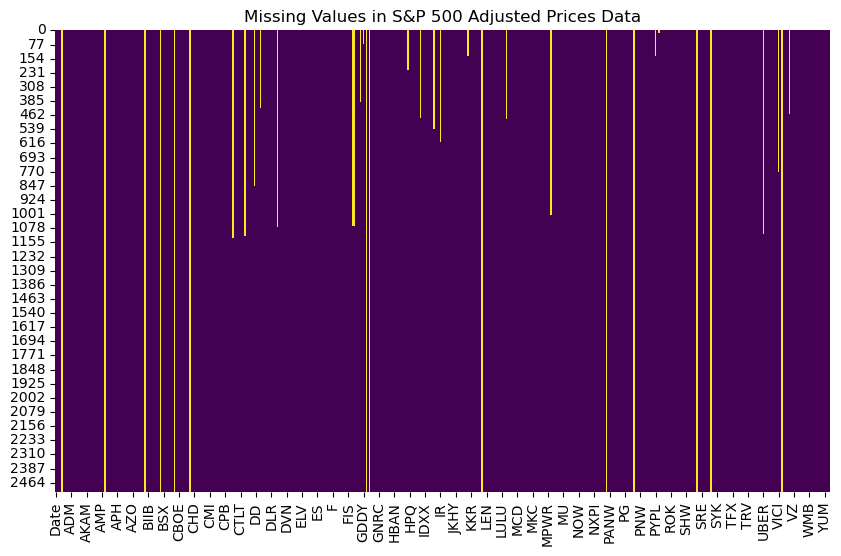

In [20]:
plt.figure(figsize=(10, 6))
sns.heatmap(sp500_adj.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in S&P 500 Adjusted Prices Data')
plt.show()

In [21]:
print("\nMissing Values in sp500_esg:")
print(sp500_esg.isnull().sum())


Missing Values in sp500_esg:
Symbol                      0
Name                        0
Address                     1
Sector                      1
Industry                    1
Full Time Employees         5
Description                 1
Total ESG Risk score       73
Environment Risk Score     73
Governance Risk Score      73
Social Risk Score          73
Controversy Level          73
Controversy Score         100
ESG Risk Percentile        73
ESG Risk Level             73
dtype: int64


Heatmap to show missing values in sp500_esg

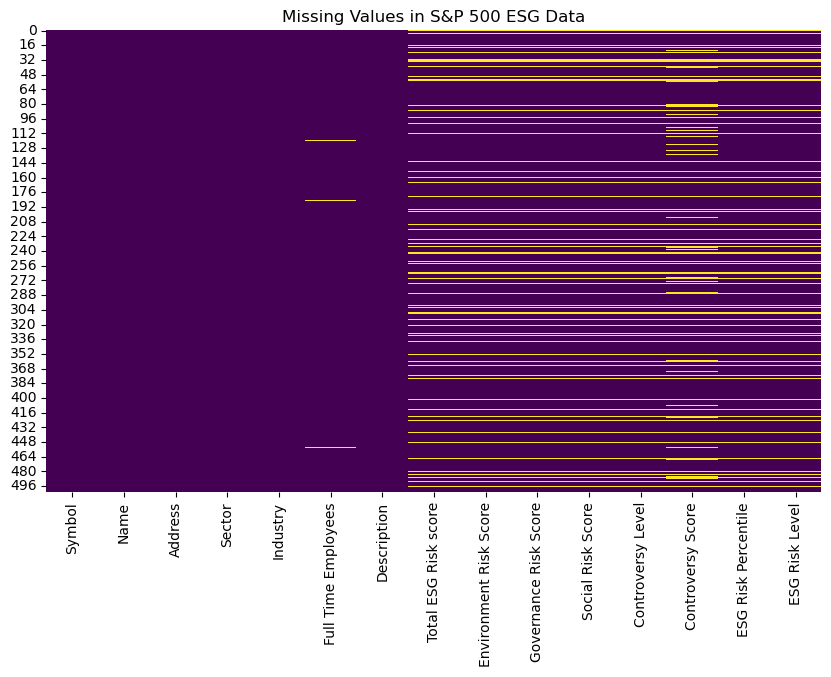

In [22]:
plt.figure(figsize=(10, 6))
sns.heatmap(sp500_esg.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in S&P 500 ESG Data')
plt.show()

# 3. Outlier Detection

In [23]:
from scipy import stats
z_scores = stats.zscore(sp500_esg.select_dtypes(include=[np.number]))
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3).all(axis=1)
print("Number of Outliers:", sum(outliers))

Number of Outliers: 0


In [24]:
# Selecting numeric columns

numeric_cols = sp500_adj.select_dtypes(include=[np.number])

# Calculating z-scores for each numeric column

adj_z_scores = (numeric_cols - numeric_cols.mean()) / numeric_cols.std()

# Identification of outliers

adj_outliers = (np.abs(adj_z_scores) > 3)

print("Sum of outliers per column:")
print(adj_outliers.sum())

Sum of outliers per column:
A       0
AAPL    0
ABBV    0
ABNB    0
ABT     0
       ..
XYL     0
YUM     0
ZBH     9
ZBRA    0
ZTS     0
Length: 503, dtype: int64


In [25]:
threshold = 3

# Defining bounds

upper_bound = numeric_cols.mean() + threshold * numeric_cols.std()
lower_bound = numeric_cols.mean() - threshold * numeric_cols.std()

# Replacing outliers with bounds

for col in numeric_cols.columns:
    sp500_adj.loc[adj_z_scores[col] > threshold, col] = upper_bound[col]
    sp500_adj.loc[adj_z_scores[col] < -threshold, col] = lower_bound[col]

print("Outliers have been capped.")
print("Updated DataFrame:")
print(sp500_adj.head())

Outliers have been capped.
Updated DataFrame:
                        Date      A   AAPL   ABBV  ABNB    ABT   ACGL    ACN  \
0  2014-12-10 00:00:00+00:00  37.13  24.93  44.68   NaN  36.67  18.40  70.98   
1  2014-12-11 00:00:00+00:00  37.39  24.86  44.32   NaN  36.75  18.43  71.11   
2  2014-12-12 00:00:00+00:00  36.56  24.44  43.15   NaN  36.11  18.30  69.43   
3  2014-12-15 00:00:00+00:00  35.60  24.10  43.38   NaN  35.92  18.24  69.41   
4  2014-12-16 00:00:00+00:00  35.41  23.77  43.14   NaN  35.87  18.24  70.25   

    ADBE    ADI  ...    WTW     WY    WYNN    XEL    XOM    XYL    YUM  \
0  69.85  45.17  ...  97.96  24.24  127.11  25.31  57.35  32.45  41.95   
1  69.74  45.66  ...  98.10  24.27  128.95  25.54  57.69  32.58  42.84   
2  76.02  45.39  ...  96.77  24.10  127.74  25.28  56.01  31.89  43.33   
3  73.04  44.99  ...  98.10  23.93  125.73  25.00  56.21  31.92  42.01   
4  72.32  44.47  ...  97.90  23.36  121.71  24.98  55.89  31.95  41.05   

      ZBH   ZBRA    ZTS  
0 

# 4. Summary Statistics

In [26]:
print("\nSummary Statistics for sp500_adj:")
print(sp500_adj.describe())


Summary Statistics for sp500_adj:
                 A         AAPL         ABBV  ABNB         ABT         ACGL  \
count  2517.000000  2517.000000  2517.000000   0.0  2517.00000  2517.000000   
mean     89.040346    92.991323    89.159853   NaN    76.43290    41.025355   
std      40.298561    64.869282    43.993173   NaN    30.54106    21.984035   
min      31.030000    20.700000    32.960000   NaN    30.86000    18.240000   
25%      56.110000    34.730000    50.310000   NaN    42.38000    26.230000   
50%      76.170000    63.490000    73.000000   NaN    77.65000    31.430000   
75%     129.180000   149.670000   130.480000   NaN   104.60000    44.270000   
max     175.480000   247.680000   203.870000   NaN   133.73000   107.045653   

               ACN         ADBE          ADI          ADM  ...          WTW  \
count  2517.000000  2517.000000  2517.000000  2517.000000  ...  2517.000000   
mean    200.847565   317.738534   114.333743    47.950830  ...   176.282368   
std      91.7428

In [27]:
print("\nSummary Statistics for sp500_esg:")
print(sp500_esg.describe())


Summary Statistics for sp500_esg:
       Total ESG Risk score  Environment Risk Score  Governance Risk Score  \
count            430.000000              430.000000             430.000000   
mean              21.533721                5.739767               6.725116   
std                6.889176                5.092421               2.208085   
min                7.100000                0.000000               3.000000   
25%               16.400000                1.800000               5.300000   
50%               21.050000                4.050000               6.100000   
75%               26.000000                8.950000               7.675000   
max               41.700000               25.000000              19.400000   

       Social Risk Score  Controversy Score  
count         430.000000         403.000000  
mean            9.070465           2.007444  
std             3.657924           0.793283  
min             0.800000           1.000000  
25%             6.700000        

# 5. Correlation Matrix

In [28]:
sp500_adj_numeric = sp500_adj.drop(columns=['Date'])

correlation_matrix = sp500_adj_numeric.corr()

print(correlation_matrix)

             A      AAPL      ABBV  ABNB       ABT      ACGL       ACN  \
A     1.000000  0.920165  0.873272   NaN  0.957985  0.709775  0.959111   
AAPL  0.920165  1.000000  0.948498   NaN  0.908329  0.863611  0.963132   
ABBV  0.873272  0.948498  1.000000   NaN  0.831579  0.903570  0.910357   
ABNB       NaN       NaN       NaN   NaN       NaN       NaN       NaN   
ABT   0.957985  0.908329  0.831579   NaN  1.000000  0.666607  0.956441   
...        ...       ...       ...   ...       ...       ...       ...   
XYL   0.943723  0.903356  0.870777   NaN  0.911874  0.799680  0.935902   
YUM   0.935064  0.921650  0.902713   NaN  0.931896  0.827169  0.952594   
ZBH   0.585841  0.422642  0.298694   NaN  0.625115  0.208442  0.513814   
ZBRA  0.887759  0.764069  0.633777   NaN  0.910517  0.439721  0.845900   
ZTS   0.954875  0.923802  0.838449   NaN  0.983401  0.692897  0.970192   

          ADBE       ADI       ADM  ...       WTW        WY      WYNN  \
A     0.909632  0.933444  0.822146  ..

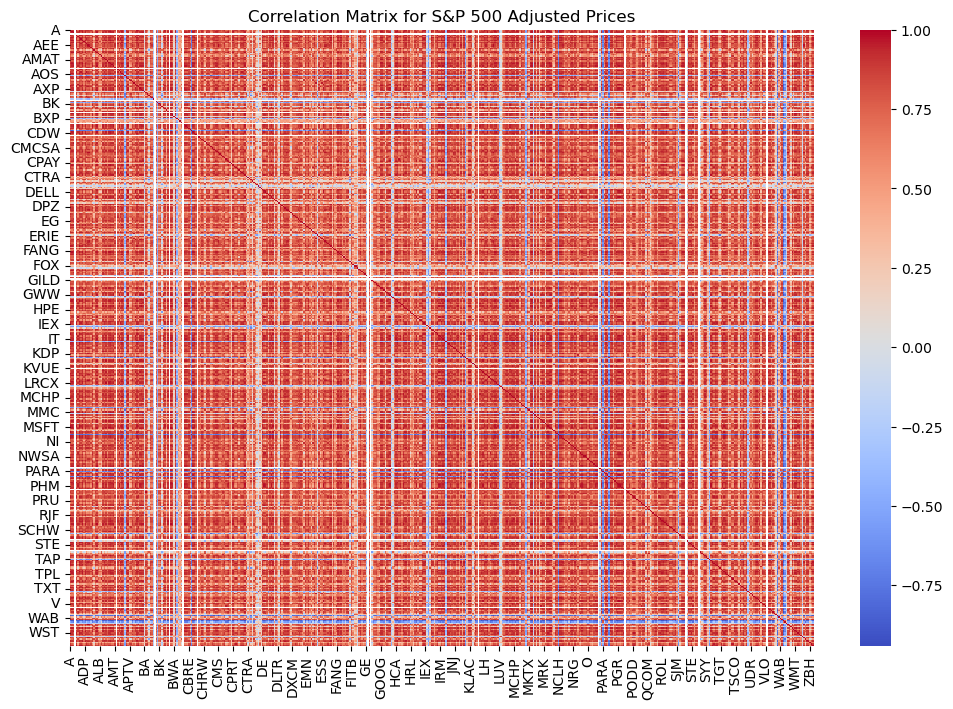

In [29]:
# Heatmap for the correlation matrix

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Matrix for S&P 500 Adjusted Prices")
plt.show()

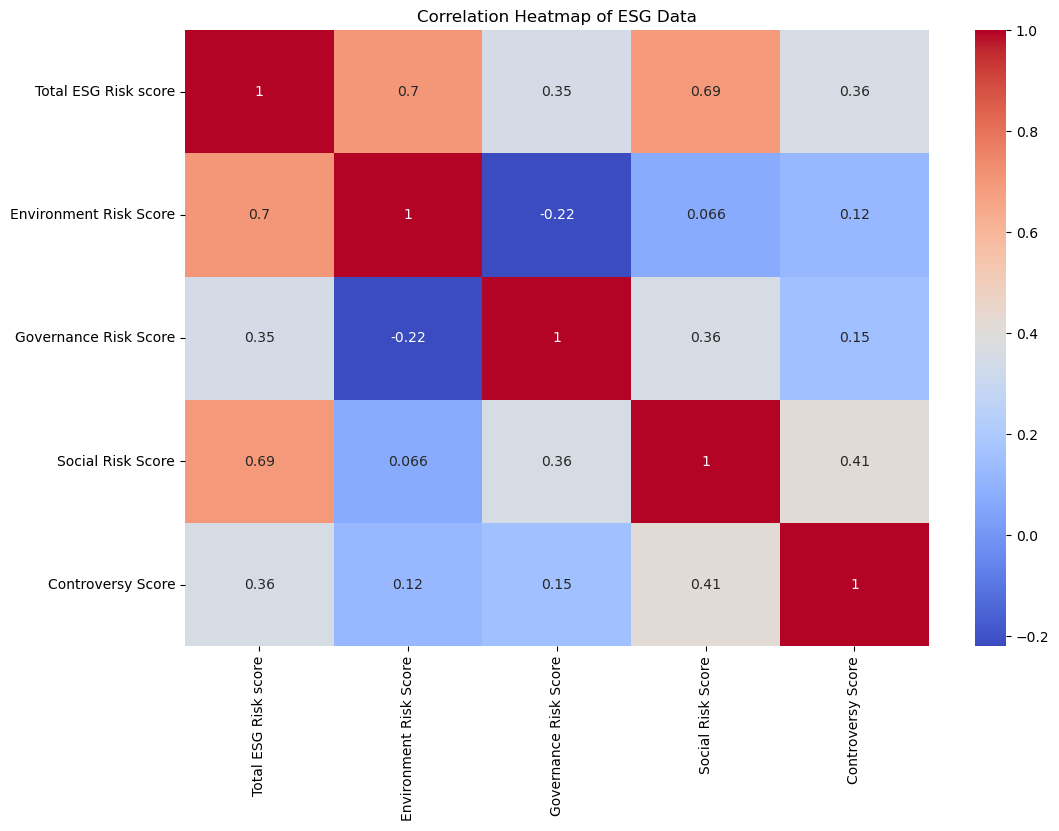

In [30]:
# Correlation heatmap for ESG data

numeric_df = sp500_esg.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of ESG Data')
plt.show()

# 6. Distribution of ESG Risk Scores

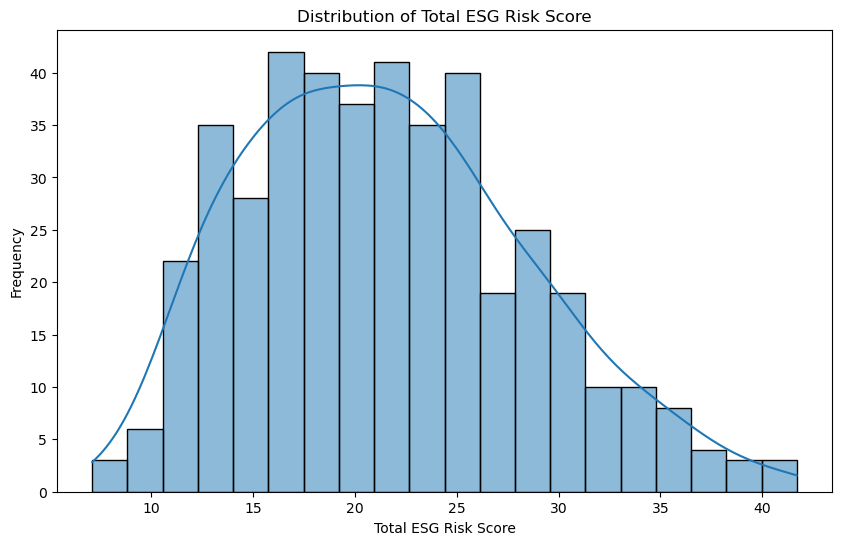

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(sp500_esg['Total ESG Risk score'].dropna(), bins=20, kde=True)
plt.title("Distribution of Total ESG Risk Score")
plt.xlabel("Total ESG Risk Score")
plt.ylabel("Frequency")
plt.show()

# 7. Count of Companies per Sector

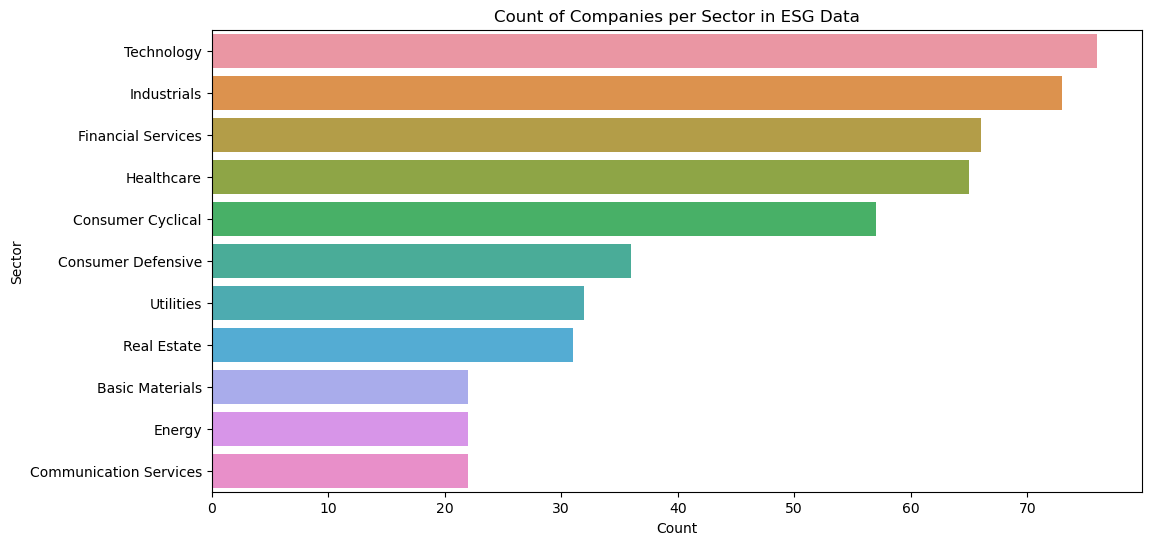

In [32]:
plt.figure(figsize=(12, 6))
sns.countplot(y='Sector', data=sp500_esg, order=sp500_esg['Sector'].value_counts().index)
plt.title("Count of Companies per Sector in ESG Data")
plt.xlabel("Count")
plt.ylabel("Sector")
plt.show()

# 8. ESG Risk Level Distribution

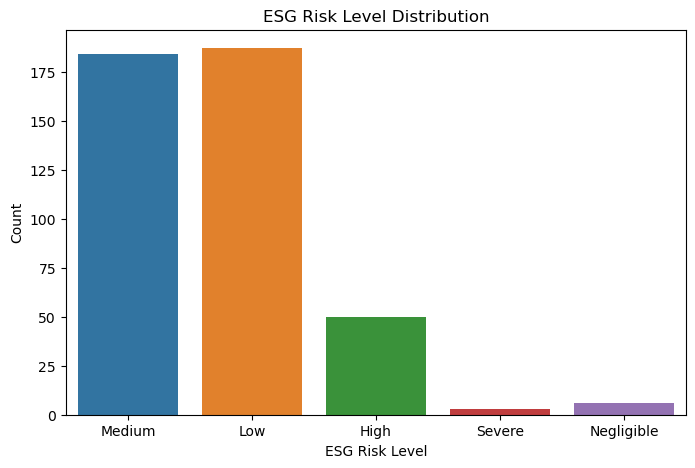

In [33]:
plt.figure(figsize=(8, 5))
sns.countplot(x='ESG Risk Level', data=sp500_esg)
plt.title("ESG Risk Level Distribution")
plt.xlabel("ESG Risk Level")
plt.ylabel("Count")
plt.show()

# 9. Sector wise Risk Analysis

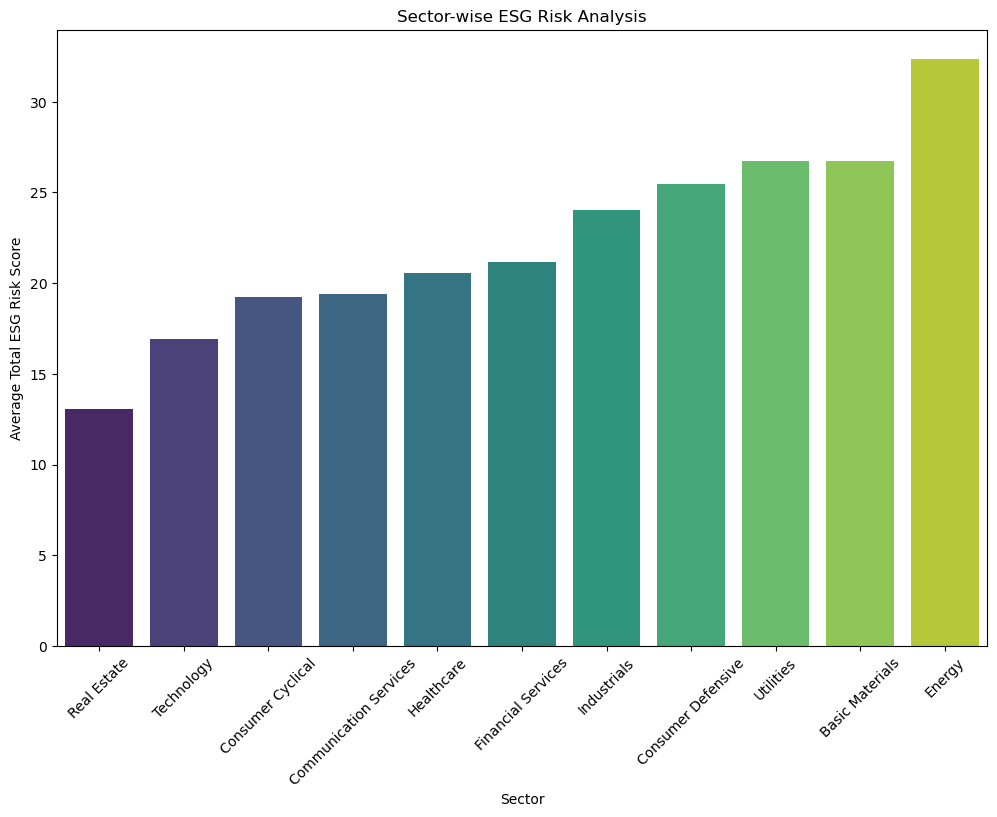

In [34]:
sector_risk = sp500_esg.groupby('Sector')['Total ESG Risk score'].mean().sort_values()

plt.figure(figsize=(12, 8))
sns.barplot(x=sector_risk.index, y=sector_risk.values, palette='viridis')
plt.xticks(rotation=45)
plt.title('Sector-wise ESG Risk Analysis')
plt.xlabel('Sector')
plt.ylabel('Average Total ESG Risk Score')
plt.show()

# 10. ESG Risk level wise top performers

In [35]:
# Sorting the data in ascending order to get companies with the lowest ESG risk

top_performers = sp500_esg.sort_values(by='Total ESG Risk score').head(10)

top_performers = top_performers.sort_values(by='Total ESG Risk score')

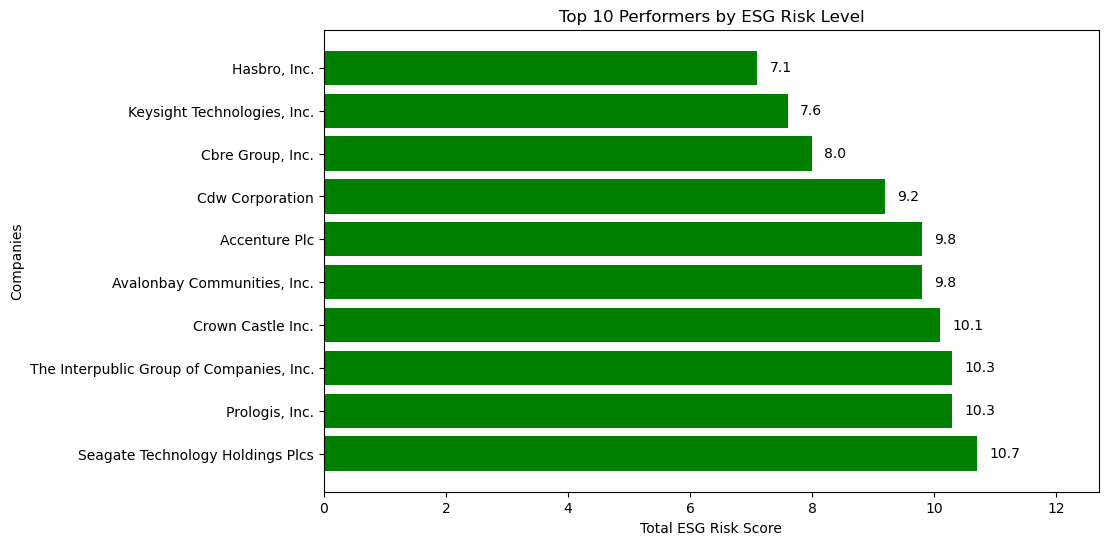

In [36]:
plt.figure(figsize=(10, 6))
plt.barh(top_performers['Name'], top_performers['Total ESG Risk score'], color='green')
plt.xlabel('Total ESG Risk Score')
plt.ylabel('Companies')
plt.title('Top 10 Performers by ESG Risk Level')
plt.xlim(0, top_performers['Total ESG Risk score'].max() + 2)  # +2 for better readability
plt.gca().invert_yaxis()  # Invert y-axis for better readability

for i, v in enumerate(top_performers['Total ESG Risk score']):
    plt.text(v + 0.2, i, str(v), color='black', verticalalignment='center')

plt.show()

# 11. ESG Risk Percentile plot

In [37]:
if not pd.api.types.is_string_dtype(sp500_esg['ESG Risk Percentile']):
    sp500_esg['ESG Risk Percentile'] = sp500_esg['ESG Risk Percentile'].astype(str)

sp500_esg['ESG Risk Percentile'] = sp500_esg['ESG Risk Percentile'].str.extract('(\d+)').astype(float)

In [38]:
bins = [0, 25, 50, 75, 100]
labels = ['0-25th', '26-50th', '51-75th', '76-100th']
sp500_esg['Percentile Group'] = pd.cut(sp500_esg['ESG Risk Percentile'], bins=bins, labels=labels, right=False)

In [39]:
# Calculating mean ESG risk score for each percentile group

mean_esg_scores = sp500_esg.groupby('Percentile Group')['Total ESG Risk score'].mean().reset_index()

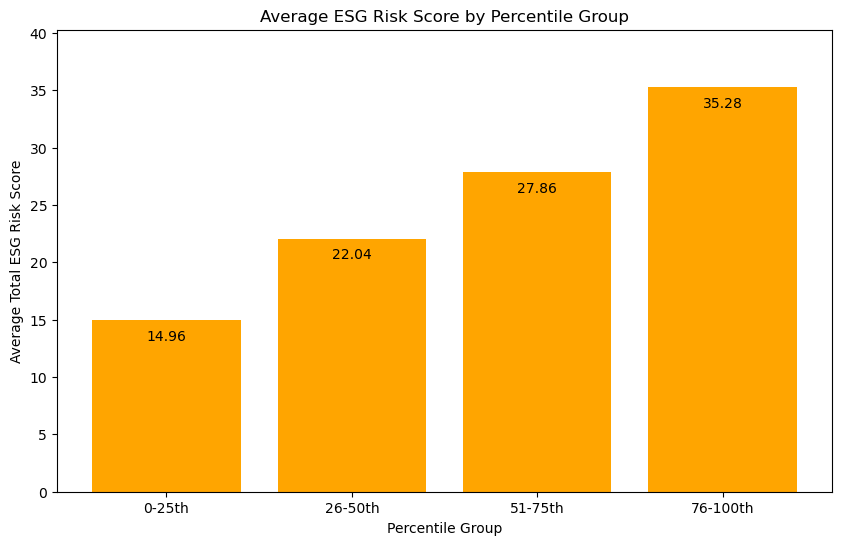

In [40]:
plt.figure(figsize=(10, 6))
bars = plt.bar(mean_esg_scores['Percentile Group'], mean_esg_scores['Total ESG Risk score'], color='orange')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval - 2, round(yval, 2), ha='center', va='bottom')

plt.xlabel('Percentile Group')
plt.ylabel('Average Total ESG Risk Score')
plt.title('Average ESG Risk Score by Percentile Group')
plt.ylim(0, max(mean_esg_scores['Total ESG Risk score']) + 5)  # +5 for better readability

plt.show()

# Handling Missing Values

Missing values in sp500_adj

In [41]:
sp500_adj.interpolate(method='linear', inplace=True)

Missing Values in sp500_esg

In [42]:
# Categorical columns

sp500_esg['Address'].fillna('Unknown', inplace=True)
sp500_esg['Sector'].fillna('Unknown', inplace=True)
sp500_esg['Industry'].fillna('Unknown', inplace=True)
sp500_esg['Description'].fillna('No Description', inplace=True)

In [43]:
# Ensuring all ESG scores are filled with a default value (0)

sp500_esg[['Total ESG Risk score', 'Environment Risk Score', 'Governance Risk Score', 'Social Risk Score']] = sp500_esg[['Total ESG Risk score', 'Environment Risk Score', 'Governance Risk Score', 'Social Risk Score']].fillna(0)

# Converting 'Full Time Employees' to numeric and replacing commas

sp500_esg['Full Time Employees'] = pd.to_numeric(
    sp500_esg['Full Time Employees'].astype(str).str.replace(',', ''), errors='coerce'
)

# Filling 'Full Time Employees' with the overall median value

overall_median_full_time_employees = sp500_esg['Full Time Employees'].median()
sp500_esg['Full Time Employees'].fillna(overall_median_full_time_employees, inplace=True)

# Filling categorical variables with 'Unknown'
# Updating categories for categorical columns before filling missing values

for col in ['Controversy Level', 'ESG Risk Level', 'ESG Risk Percentile', 'Percentile Group']:
    if sp500_esg[col].dtype.name == 'category':  # Check if column is categorical
        sp500_esg[col] = sp500_esg[col].cat.add_categories('Unknown')
    sp500_esg[col].fillna('Unknown', inplace=True)

# Filling missing Controversy Score with a default value (0)

sp500_esg['Controversy Score'].fillna(0, inplace=True)

print(sp500_esg.isna().sum())

Symbol                    0
Name                      0
Address                   0
Sector                    0
Industry                  0
Full Time Employees       0
Description               0
Total ESG Risk score      0
Environment Risk Score    0
Governance Risk Score     0
Social Risk Score         0
Controversy Level         0
Controversy Score         0
ESG Risk Percentile       0
ESG Risk Level            0
Percentile Group          0
dtype: int64


In [44]:
sp500_esg.head()

,Symbol,Name,Address,Sector,Industry,Full Time Employees,Description,Total ESG Risk score,Environment Risk Score,Governance Risk Score,Social Risk Score,Controversy Level,Controversy Score,ESG Risk Percentile,ESG Risk Level,Percentile Group
0,ENPH,"Enphase Energy, Inc.","47281 Bayside Parkway\nFremont, CA 94538\nUnit...",Technology,Solar,3157.0,"Enphase Energy, Inc., together with its subsid...",0.0,0.0,0.0,0.0,Unknown,0.0,Unknown,Unknown,Unknown
1,EMN,Eastman Chemical Company,"200 South Wilcox Drive\nKingsport, TN 37662\nU...",Basic Materials,Specialty Chemicals,14000.0,Eastman Chemical Company operates as a special...,25.3,12.8,6.6,5.8,Moderate Controversy Level,2.0,50.0,Medium,51-75th
2,DPZ,Domino's Pizza Inc.,"30 Frank Lloyd Wright Drive\nAnn Arbor, MI 481...",Consumer Cyclical,Restaurants,6500.0,"Domino's Pizza, Inc., through its subsidiaries...",29.2,10.6,6.3,12.2,Moderate Controversy Level,2.0,66.0,Medium,51-75th
3,DAY,"Dayforce, Inc.","3311 East Old Shakopee Road\nMinneapolis, MN 5...",Technology,Software - Application,9084.0,"Dayforce Inc., together with its subsidiaries,...",0.0,0.0,0.0,0.0,Unknown,0.0,Unknown,Unknown,Unknown
4,DVA,Davita Inc.,"2000 16th Street\nDenver, CO 80202\nUnited States",Healthcare,Medical Care Facilities,70000.0,DaVita Inc. provides kidney dialysis services ...,22.6,0.1,8.4,14.1,Moderate Controversy Level,2.0,38.0,Medium,26-50th


Merging both Datasets

In [45]:
# Transposing sp500_adj to align tickers

sp500_adj_transposed = sp500_adj.set_index('Date').T.reset_index()
sp500_adj_transposed.columns = ['Symbol'] + sp500_adj['Date'].unique().tolist()  # Rename columns

In [46]:
# Merging the two datasets on 'Symbol'

sp500_merged = pd.merge(sp500_esg, sp500_adj_transposed, on='Symbol', how='inner')

In [47]:
sp500_merged.to_csv('sp500_merged.csv', index=False)

sp500_merged.head()

,Symbol,Name,Address,Sector,Industry,Full Time Employees,Description,Total ESG Risk score,Environment Risk Score,Governance Risk Score,...,2024-11-26 00:00:00+00:00,2024-11-27 00:00:00+00:00,2024-11-29 00:00:00+00:00,2024-12-02 00:00:00+00:00,2024-12-03 00:00:00+00:00,2024-12-04 00:00:00+00:00,2024-12-05 00:00:00+00:00,2024-12-06 00:00:00+00:00,2024-12-09 00:00:00+00:00,2024-12-10 00:00:00+00:00
0,ENPH,"Enphase Energy, Inc.","47281 Bayside Parkway\nFremont, CA 94538\nUnit...",Technology,Solar,3157.0,"Enphase Energy, Inc., together with its subsid...",0.0,0.0,0.0,...,70.500000,72.360000,71.350000,75.12,73.260000,73.12,70.34,71.56,76.39,75.10
1,EMN,Eastman Chemical Company,"200 South Wilcox Drive\nKingsport, TN 37662\nU...",Basic Materials,Specialty Chemicals,14000.0,Eastman Chemical Company operates as a special...,25.3,12.8,6.6,...,104.970000,104.230000,104.720000,104.27,102.940000,101.94,101.51,101.07,100.08,99.69
2,DPZ,Domino's Pizza Inc.,"30 Frank Lloyd Wright Drive\nAnn Arbor, MI 481...",Consumer Cyclical,Restaurants,6500.0,"Domino's Pizza, Inc., through its subsidiaries...",29.2,10.6,6.3,...,472.910000,472.340000,476.190000,466.18,462.220000,466.86,465.41,459.59,457.74,457.32
3,DAY,"Dayforce, Inc.","3311 East Old Shakopee Road\nMinneapolis, MN 5...",Technology,Software - Application,9084.0,"Dayforce Inc., together with its subsidiaries,...",0.0,0.0,0.0,...,79.680000,79.870000,79.990000,81.39,80.490000,80.71,77.21,78.56,79.23,78.19
4,DVA,Davita Inc.,"2000 16th Street\nDenver, CO 80202\nUnited States",Healthcare,Medical Care Facilities,70000.0,DaVita Inc. provides kidney dialysis services ...,22.6,0.1,8.4,...,163.813337,163.813337,163.813337,163.74,163.813337,163.38,161.37,160.25,158.06,152.45


In [48]:
# Checking for missing values after merge

print("Missing values after merge:")
print(sp500_merged.isnull().sum())

Missing values after merge:
Symbol                        0
Name                          0
Address                       0
Sector                        0
Industry                      0
                             ..
2024-12-04 00:00:00+00:00    10
2024-12-05 00:00:00+00:00    10
2024-12-06 00:00:00+00:00    10
2024-12-09 00:00:00+00:00    10
2024-12-10 00:00:00+00:00    10
Length: 2533, dtype: int64


In [49]:
# Identifying time-series columns for years 2014 to 2024

time_series_columns = [col for col in sp500_merged.columns if any(str(year) in col for year in range(2014, 2025))]

# Forward and backward fill for time-series columns
#sp500_merged[time_series_columns] = sp500_merged[time_series_columns].fillna(method='ffill').fillna(method='bfill')

# Alternatively, you can use interpolation for a smoother imputation:
sp500_merged[time_series_columns] = sp500_merged[time_series_columns].interpolate(method='linear', axis=0)

# Verify that no missing values remain in the time-series columns
missing_after_fill = sp500_merged[time_series_columns].isnull().sum().sum()
print(f"Total missing values in time-series columns after fill/interpolation: {missing_after_fill}")

Total missing values in time-series columns after fill/interpolation: 0


# Correlation between ESG Risk Scores and Stock Prices

In [50]:
latest_price_col = sp500_merged.columns[-1]  # Last column representing the latest stock price

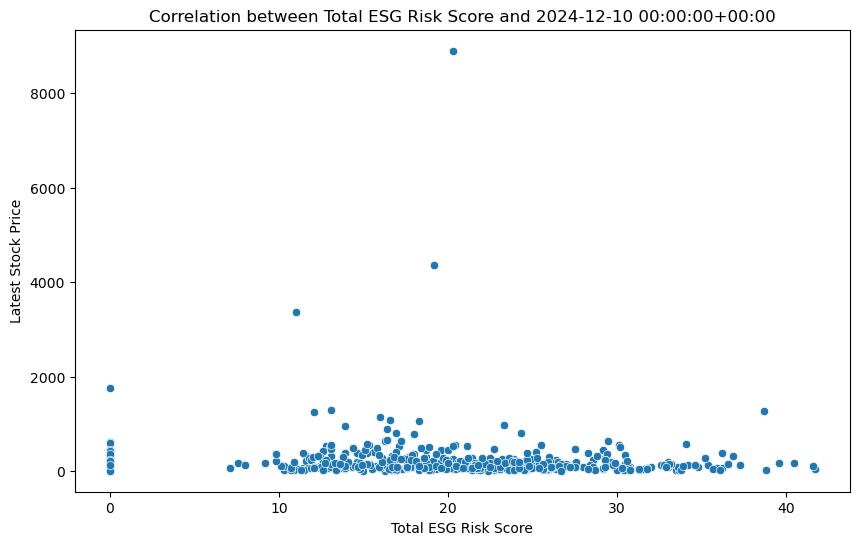

In [51]:
# Correlation between Total ESG Risk Score and latest stock price

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Total ESG Risk score', y=latest_price_col, data=sp500_merged)
plt.title(f"Correlation between Total ESG Risk Score and {latest_price_col}")
plt.xlabel("Total ESG Risk Score")
plt.ylabel("Latest Stock Price")
plt.show()

# Sector-wise analysis of ESG Risk vs Stock Performance

In [52]:
# Calculating sector-wise median stock price and ESG scores

sector_analysis = sp500_merged.groupby('Sector')[[latest_price_col, 'Total ESG Risk score']].median().reset_index()

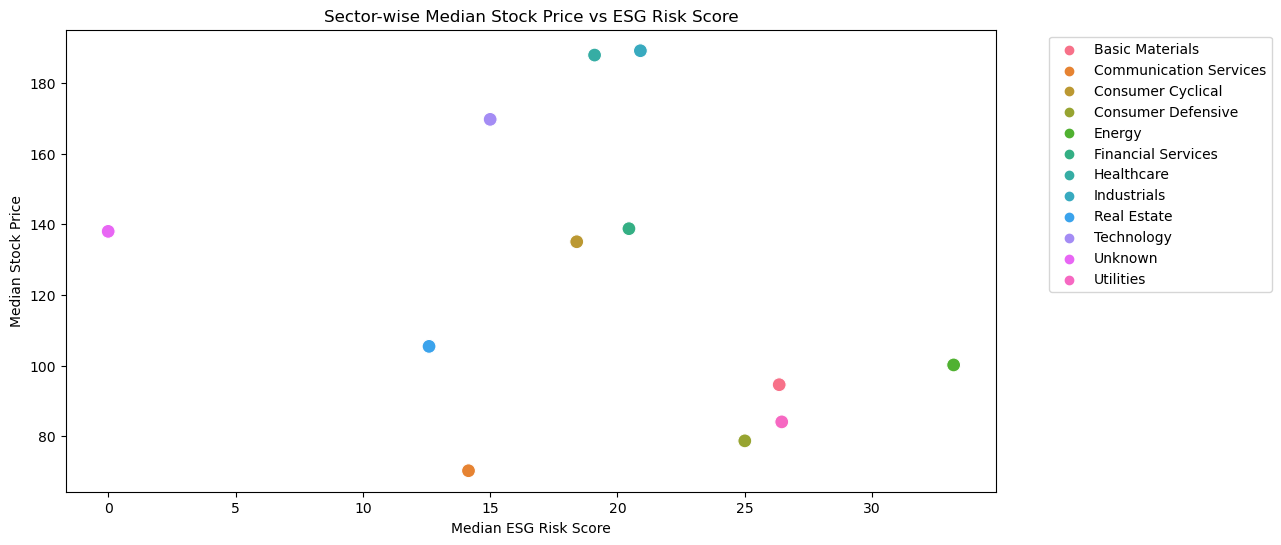

In [53]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Total ESG Risk score', y=latest_price_col, hue='Sector', data=sector_analysis, s=100)
plt.title("Sector-wise Median Stock Price vs ESG Risk Score")
plt.xlabel("Median ESG Risk Score")
plt.ylabel("Median Stock Price")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Boxplot of ESG Risk Level vs Stock Performance

In [54]:
print(sp500_merged[['ESG Risk Level', latest_price_col]].isna().sum())

ESG Risk Level               0
2024-12-10 00:00:00+00:00    0
dtype: int64


In [55]:
print(sp500_merged['ESG Risk Level'].unique())

['Unknown' 'Medium' 'Low' 'High' 'Severe' 'Negligible']


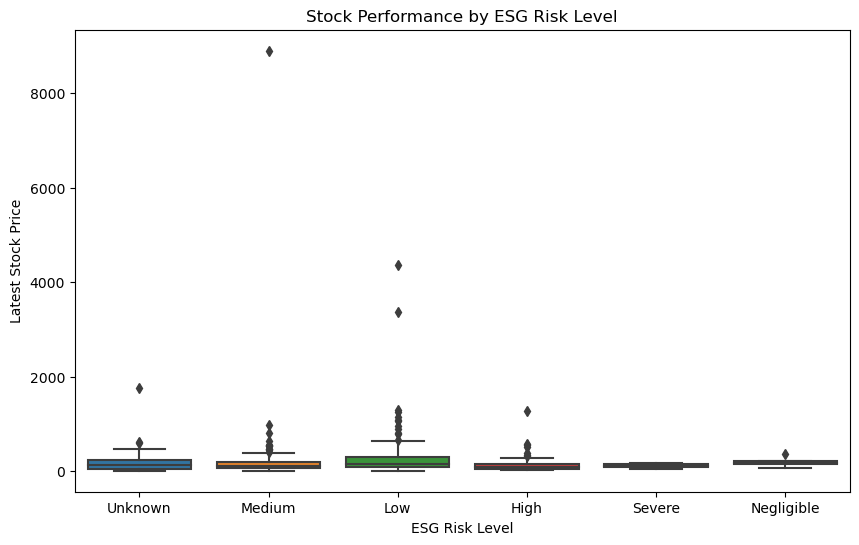

In [56]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='ESG Risk Level', y=latest_price_col, data=sp500_merged)
plt.title("Stock Performance by ESG Risk Level")
plt.xlabel("ESG Risk Level")
plt.ylabel("Latest Stock Price")
plt.show()

# ESG Controversy Level vs Stock Performance

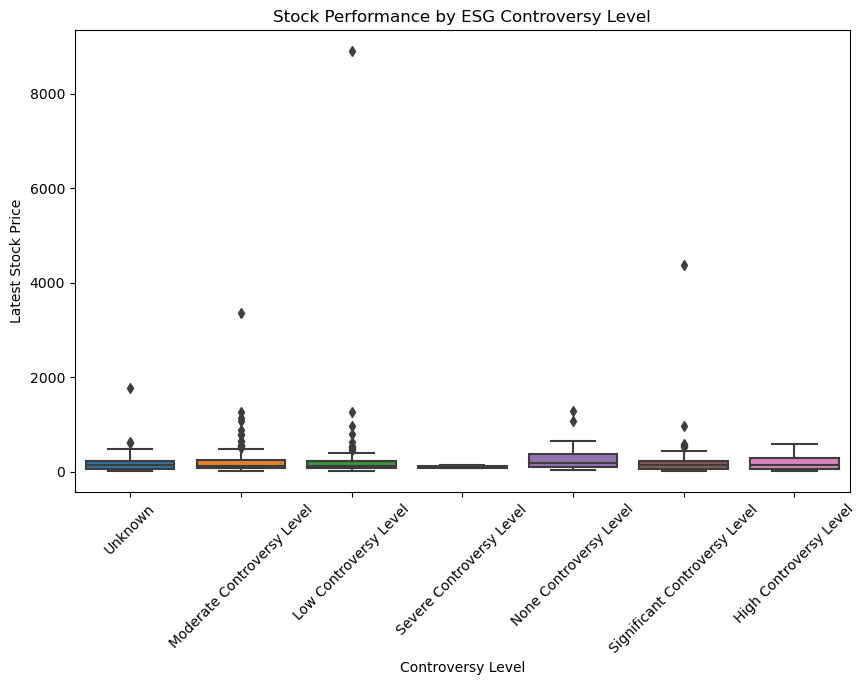

In [57]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Controversy Level', y=latest_price_col, data=sp500_merged)
plt.title("Stock Performance by ESG Controversy Level")
plt.xlabel("Controversy Level")
plt.ylabel("Latest Stock Price")
plt.xticks(rotation=45)
plt.show()

# Data Preparation for LSTM and SVM

Step 1: Data Cleaning

In [58]:
sp500_merged = sp500_merged.drop_duplicates()

# Handling missing values

numeric_columns = sp500_merged.select_dtypes(include=['float64', 'int64']).columns
sp500_merged[numeric_columns] = sp500_merged[numeric_columns].fillna(sp500_merged[numeric_columns].mean())

categorical_columns = sp500_merged.select_dtypes(include=['object']).columns
for col in categorical_columns:
    sp500_merged[col].fillna(sp500_merged[col].mode()[0], inplace=True)

Step 2: Normalize Financial and ESG Data

In [59]:
financial_columns = [col for col in sp500_merged.columns if '2024' in col]
scaler_lstm = MinMaxScaler()
sp500_merged[financial_columns] = scaler_lstm.fit_transform(sp500_merged[financial_columns])

scaler_svm = StandardScaler()
sp500_merged[numeric_columns] = scaler_svm.fit_transform(sp500_merged[numeric_columns])

Step 3: Feature Engineering

In [60]:
for col in financial_columns:
    sp500_merged[f"{col}_rolling_avg"] = sp500_merged[col].rolling(window=5, min_periods=1).mean()
    sp500_merged[f"{col}_volatility"] = sp500_merged[col].rolling(window=5, min_periods=1).std()

Step 4: Map ESG Scores

In [61]:
sp500_merged['ESG_Weighted_Score'] = (
    0.4 * sp500_merged['Total ESG Risk score'] +
    0.3 * sp500_merged['Environment Risk Score'] +
    0.2 * sp500_merged['Social Risk Score'] +
    0.1 * sp500_merged['Governance Risk Score']
)

Step 5: Preparing Data for LSTM

In [62]:
time_window = 5
lstm_data = []
lstm_targets = []

for i in range(len(sp500_merged) - time_window):
    lstm_data.append(sp500_merged[financial_columns].iloc[i:i + time_window].values)
    lstm_targets.append(sp500_merged[financial_columns].iloc[i + time_window].values)

lstm_data = np.array(lstm_data)
lstm_targets = np.array(lstm_targets)

Step 6: Feature Selection for SVM

In [63]:
important_features = financial_columns + ['ESG_Weighted_Score']
svm_data = sp500_merged[important_features]

# Saving the preprocessed datasets

sp500_merged.to_csv('preprocessed_sp500_merged.csv', index=False)
np.save('lstm_data.npy', lstm_data)
np.save('lstm_targets.npy', lstm_targets)
svm_data.to_csv('svm_data.csv', index=False)

print("\nPreprocessing completed!")
print("1. Preprocessed dataset saved as 'preprocessed_sp500_merged.csv'")
print("2. LSTM data saved as 'lstm_data.npy' and 'lstm_targets.npy'")
print("3. SVM-ready data saved as 'svm_data.csv'")


Preprocessing completed!
1. Preprocessed dataset saved as 'preprocessed_sp500_merged.csv'
2. LSTM data saved as 'lstm_data.npy' and 'lstm_targets.npy'
3. SVM-ready data saved as 'svm_data.csv'


# MODEL DEVELOPMENT

# (a) LSTM

Step 1: Train the Model on Training Set and Evaluate on Validation Set

In [64]:
# Loading LSTM data

lstm_data = np.load('lstm_data.npy')
lstm_targets = np.load('lstm_targets.npy')

# Splitting the data: 70% train, 15% validation, 15% test

X_train, X_temp, y_train, y_temp = train_test_split(lstm_data, lstm_targets, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (341, 5, 238)
Validation data shape: (73, 5, 238)
Test data shape: (74, 5, 238)


In [65]:
# Training and evaluating the model on validation set

lstm_initial_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1])  # Output layer
])

lstm_initial_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Training the model

lstm_initial_history = lstm_initial_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluating on validation set

lstm_y_val_pred_initial = lstm_initial_model.predict(X_val)
lstm_mse_val_initial = mean_squared_error(y_val, lstm_y_val_pred_initial)
lstm_mae_val_initial = mean_absolute_error(y_val, lstm_y_val_pred_initial)
lstm_r2_val_initial = r2_score(y_val, lstm_y_val_pred_initial)

print(f"Initial Model Validation Metrics:")
print(f"MSE: {lstm_mse_val_initial:.4f}, MAE: {lstm_mae_val_initial:.4f}, R²: {lstm_r2_val_initial:.4f}")

2024-12-10 19:15:57.044412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:15:57.046024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:15:57.046765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-12-10 19:15:57.106964: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-12-10 19:15:57.254301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:15:57.255034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:15:57.255739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG IN

11/11 [==============================] - 1s 22ms/step - loss: 1.2020 - mae: 0.3744 - val_loss: 0.9651 - val_mae: 0.3449
Epoch 2/20
11/11 [==============================] - 0s 4ms/step - loss: 1.2017 - mae: 0.3740 - val_loss: 0.9646 - val_mae: 0.3439
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 1.2009 - mae: 0.3743 - val_loss: 0.9649 - val_mae: 0.3467
Epoch 4/20
 1/11 [=>............................] - ETA: 0s - loss: 0.2290 - mae: 0.2992

2024-12-10 19:15:57.977430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:15:57.977884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:15:57.978303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 0s 5ms/step - loss: 1.1996 - mae: 0.3763 - val_loss: 0.9656 - val_mae: 0.3493
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 1.1979 - mae: 0.3770 - val_loss: 0.9675 - val_mae: 0.3523
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 1.1956 - mae: 0.3771 - val_loss: 0.9683 - val_mae: 0.3517
Epoch 7/20
11/11 [==============================] - 0s 5ms/step - loss: 1.1929 - mae: 0.3789 - val_loss: 0.9730 - val_mae: 0.3610
Epoch 8/20
11/11 [==============================] - 0s 4ms/step - loss: 1.1880 - mae: 0.3798 - val_loss: 0.9738 - val_mae: 0.3606
Epoch 9/20
11/11 [==============================] - 0s 4ms/step - loss: 1.1809 - mae: 0.3806 - val_loss: 0.9805 - val_mae: 0.3695
Epoch 10/20
11/11 [==============================] - 0s 5ms/step - loss: 1.1716 - mae: 0.3805 - val_loss: 0.9832 - val_mae: 0.3701
Epoch 11/20
11/11 [==============================] - 0s 5ms/step - loss: 1.1595 - mae: 0.3795 - val_

2024-12-10 19:15:59.105785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:15:59.106255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:15:59.106817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Step 2: Performing Hyperparameter Tuning on Training Set and Evaluating on Validation Set

In [66]:
best_lstm_model = None
best_lstm_mse = float('inf')
lstm_hyperparameter_results = []

unit_options = [64, 128]
learning_rate_options = [0.001, 0.0005]
batch_size_options = [16, 32]
epochs = 50

for units in unit_options:
    for learning_rate in learning_rate_options:
        for batch_size in batch_size_options:
            print(f"Training with units={units}, learning_rate={learning_rate}, batch_size={batch_size}")
            
            hyperlstm_model = Sequential([
                LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
                Dense(units // 2, activation='relu'),
                Dense(y_train.shape[1])
            ])
            hyperlstm_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
            
            early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            
            history = hyperlstm_model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[early_stop],
                verbose=1
            )
            
            lstm_y_val_pred = hyperlstm_model.predict(X_val)
            lstm_mse_val = mean_squared_error(y_val, lstm_y_val_pred)
            lstm_mae_val = mean_absolute_error(y_val, lstm_y_val_pred)
            lstm_r2_val = r2_score(y_val, lstm_y_val_pred)
            
            print(f"Validation MSE: {lstm_mse_val:.4f}, MAE: {lstm_mae_val:.4f}, R²: {lstm_r2_val:.4f}")
            
            # Saving results
            lstm_hyperparameter_results.append({
                'units': units,
                'learning_rate': learning_rate,
                'batch_size': batch_size,
                'mse': lstm_mse_val,
                'mae': lstm_mae_val,
                'r2': lstm_r2_val
            })
            
            # Updating best model
            if lstm_mse_val < best_lstm_mse:
                best_lstm_mse = lstm_mse_val
                best_lstm_model = hyperlstm_model
                best_config = (units, learning_rate, batch_size)

print(f"Best Configuration: {best_config}")

Training with units=64, learning_rate=0.001, batch_size=16


2024-12-10 19:15:59.254308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:15:59.254736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:15:59.255330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-10 19:15:59.386067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:15:59.386629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:15:59.387491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

22/22 [==============================] - 1s 11ms/step - loss: 1.2046 - mae: 0.3692 - val_loss: 0.9636 - val_mae: 0.3380
Epoch 2/50
22/22 [==============================] - 0s 3ms/step - loss: 1.2024 - mae: 0.3713 - val_loss: 0.9640 - val_mae: 0.3417
Epoch 3/50
 1/22 [>.............................] - ETA: 0s - loss: 0.1982 - mae: 0.3616

2024-12-10 19:16:00.059953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:16:00.060429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:16:00.060976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

22/22 [==============================] - 0s 3ms/step - loss: 1.2020 - mae: 0.3720 - val_loss: 0.9640 - val_mae: 0.3428
Epoch 4/50
22/22 [==============================] - 0s 3ms/step - loss: 1.2015 - mae: 0.3736 - val_loss: 0.9648 - val_mae: 0.3432
Epoch 5/50
22/22 [==============================] - 0s 3ms/step - loss: 1.2011 - mae: 0.3736 - val_loss: 0.9643 - val_mae: 0.3437
Epoch 6/50
3/3 [==============================] - 0s 1ms/step
Validation MSE: 0.9636, MAE: 0.3380, R²: -0.0007
Training with units=64, learning_rate=0.001, batch_size=32


2024-12-10 19:16:00.608577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:16:00.609041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:16:00.609464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-10 19:16:00.870397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:16:00.871439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:16:00.872382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 1s 20ms/step - loss: 1.2025 - mae: 0.3731 - val_loss: 0.9640 - val_mae: 0.3433
Epoch 2/50
11/11 [==============================] - 0s 4ms/step - loss: 1.2019 - mae: 0.3728 - val_loss: 0.9638 - val_mae: 0.3434
Epoch 3/50
11/11 [==============================] - 0s 4ms/step - loss: 1.2012 - mae: 0.3738 - val_loss: 0.9645 - val_mae: 0.3454
Epoch 4/50
 1/11 [=>............................] - ETA: 0s - loss: 0.2521 - mae: 0.3493

2024-12-10 19:16:01.520030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:16:01.520518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:16:01.521048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 0s 4ms/step - loss: 1.2003 - mae: 0.3740 - val_loss: 0.9646 - val_mae: 0.3456
Epoch 5/50
11/11 [==============================] - 0s 5ms/step - loss: 1.1995 - mae: 0.3760 - val_loss: 0.9664 - val_mae: 0.3496
Epoch 6/50
11/11 [==============================] - 0s 4ms/step - loss: 1.1963 - mae: 0.3775 - val_loss: 0.9672 - val_mae: 0.3514
Epoch 7/50
3/3 [==============================] - 0s 1ms/step
Validation MSE: 0.9638, MAE: 0.3434, R²: -0.0009
Training with units=64, learning_rate=0.0005, batch_size=16


2024-12-10 19:16:01.979026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:16:01.979472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:16:01.980024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-10 19:16:02.244305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:16:02.244810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:16:02.245375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

22/22 [==============================] - 1s 10ms/step - loss: 1.2042 - mae: 0.3705 - val_loss: 0.9643 - val_mae: 0.3371
Epoch 2/50
22/22 [==============================] - 0s 3ms/step - loss: 1.2017 - mae: 0.3706 - val_loss: 0.9634 - val_mae: 0.3408
Epoch 3/50
22/22 [==============================] - ETA: 0s - loss: 1.2016 - mae: 0.3721

2024-12-10 19:16:03.065552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:16:03.066125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:16:03.066734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

22/22 [==============================] - 0s 3ms/step - loss: 1.2016 - mae: 0.3721 - val_loss: 0.9638 - val_mae: 0.3420
Epoch 4/50
22/22 [==============================] - 0s 3ms/step - loss: 1.2012 - mae: 0.3725 - val_loss: 0.9640 - val_mae: 0.3423
Epoch 5/50
22/22 [==============================] - 0s 3ms/step - loss: 1.2008 - mae: 0.3719 - val_loss: 0.9644 - val_mae: 0.3424
Epoch 6/50
22/22 [==============================] - 0s 3ms/step - loss: 1.1997 - mae: 0.3736 - val_loss: 0.9649 - val_mae: 0.3457
Epoch 7/50
3/3 [==============================] - 0s 1ms/step
Validation MSE: 0.9634, MAE: 0.3408, R²: -0.0004
Training with units=64, learning_rate=0.0005, batch_size=32


2024-12-10 19:16:03.658908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:16:03.659436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:16:03.660073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-10 19:16:03.915877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:16:03.916377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:16:03.917042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 1s 20ms/step - loss: 1.2022 - mae: 0.3739 - val_loss: 0.9644 - val_mae: 0.3440
Epoch 2/50
11/11 [==============================] - 0s 3ms/step - loss: 1.2013 - mae: 0.3745 - val_loss: 0.9647 - val_mae: 0.3460
Epoch 3/50
11/11 [==============================] - 0s 4ms/step - loss: 1.2003 - mae: 0.3747 - val_loss: 0.9647 - val_mae: 0.3463
Epoch 4/50
 1/11 [=>............................] - ETA: 0s - loss: 9.6627 - mae: 0.7730

2024-12-10 19:16:04.560323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:16:04.560818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:16:04.561274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 0s 4ms/step - loss: 1.1999 - mae: 0.3753 - val_loss: 0.9656 - val_mae: 0.3476
Epoch 5/50
11/11 [==============================] - 0s 5ms/step - loss: 1.1987 - mae: 0.3750 - val_loss: 0.9659 - val_mae: 0.3479
Epoch 6/50
11/11 [==============================] - 0s 4ms/step - loss: 1.1976 - mae: 0.3755 - val_loss: 0.9663 - val_mae: 0.3482


2024-12-10 19:16:04.964493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:16:04.964939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:16:04.965448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 0s 1ms/step
Validation MSE: 0.9644, MAE: 0.3440, R²: -0.0016
Training with units=128, learning_rate=0.001, batch_size=16


2024-12-10 19:16:05.108431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:16:05.108871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:16:05.109484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-10 19:16:05.230650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:16:05.231171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:16:05.231647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

22/22 [==============================] - 1s 12ms/step - loss: 1.2029 - mae: 0.3736 - val_loss: 0.9642 - val_mae: 0.3411
Epoch 2/50
22/22 [==============================] - 0s 4ms/step - loss: 1.2036 - mae: 0.3723 - val_loss: 0.9634 - val_mae: 0.3429
Epoch 3/50
 1/22 [>.............................] - ETA: 0s - loss: 0.1361 - mae: 0.2546

2024-12-10 19:16:05.922384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:16:05.922856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:16:05.923570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

22/22 [==============================] - 0s 5ms/step - loss: 1.2018 - mae: 0.3733 - val_loss: 0.9631 - val_mae: 0.3432
Epoch 4/50
22/22 [==============================] - 0s 4ms/step - loss: 1.2013 - mae: 0.3741 - val_loss: 0.9639 - val_mae: 0.3455
Epoch 5/50
22/22 [==============================] - 0s 4ms/step - loss: 1.2005 - mae: 0.3759 - val_loss: 0.9656 - val_mae: 0.3477
Epoch 6/50
22/22 [==============================] - 0s 5ms/step - loss: 1.1979 - mae: 0.3781 - val_loss: 0.9688 - val_mae: 0.3559
Epoch 7/50
22/22 [==============================] - 0s 5ms/step - loss: 1.1949 - mae: 0.3763 - val_loss: 0.9726 - val_mae: 0.3624
Epoch 8/50
22/22 [==============================] - 0s 5ms/step - loss: 1.1854 - mae: 0.3798 - val_loss: 0.9860 - val_mae: 0.3814


2024-12-10 19:16:06.803906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:16:06.804341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:16:06.804939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 0s 2ms/step
Validation MSE: 0.9631, MAE: 0.3432, R²: -0.0002
Training with units=128, learning_rate=0.001, batch_size=32


2024-12-10 19:16:06.944070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:16:06.944791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:16:06.945262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-10 19:16:07.068980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:16:07.069504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:16:07.069986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 1s 21ms/step - loss: 1.2033 - mae: 0.3732 - val_loss: 0.9642 - val_mae: 0.3415
Epoch 2/50
11/11 [==============================] - 0s 5ms/step - loss: 1.2023 - mae: 0.3715 - val_loss: 0.9633 - val_mae: 0.3407
Epoch 3/50
 1/11 [=>............................] - ETA: 0s - loss: 0.2968 - mae: 0.3593

2024-12-10 19:16:07.733474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:16:07.734098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:16:07.734618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 0s 6ms/step - loss: 1.2018 - mae: 0.3725 - val_loss: 0.9638 - val_mae: 0.3427
Epoch 4/50
11/11 [==============================] - 0s 6ms/step - loss: 1.2014 - mae: 0.3739 - val_loss: 0.9636 - val_mae: 0.3440
Epoch 5/50
11/11 [==============================] - 0s 6ms/step - loss: 1.2008 - mae: 0.3744 - val_loss: 0.9645 - val_mae: 0.3459
Epoch 6/50
11/11 [==============================] - 0s 6ms/step - loss: 1.2000 - mae: 0.3765 - val_loss: 0.9660 - val_mae: 0.3486
Epoch 7/50
3/3 [==============================] - 0s 1ms/step
Validation MSE: 0.9633, MAE: 0.3407, R²: -0.0004
Training with units=128, learning_rate=0.0005, batch_size=16


2024-12-10 19:16:08.304724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:16:08.305167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:16:08.305586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-10 19:16:08.565005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:16:08.565631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:16:08.566186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

22/22 [==============================] - 1s 12ms/step - loss: 1.2033 - mae: 0.3745 - val_loss: 0.9651 - val_mae: 0.3445
Epoch 2/50
22/22 [==============================] - 0s 4ms/step - loss: 1.2011 - mae: 0.3746 - val_loss: 0.9643 - val_mae: 0.3454
Epoch 3/50
 1/22 [>.............................] - ETA: 0s - loss: 0.1185 - mae: 0.3013

2024-12-10 19:16:09.254515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:16:09.255000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:16:09.255437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

22/22 [==============================] - 0s 5ms/step - loss: 1.2006 - mae: 0.3739 - val_loss: 0.9664 - val_mae: 0.3467
Epoch 4/50
22/22 [==============================] - 0s 5ms/step - loss: 1.1991 - mae: 0.3772 - val_loss: 0.9689 - val_mae: 0.3526
Epoch 5/50
22/22 [==============================] - 0s 5ms/step - loss: 1.1967 - mae: 0.3776 - val_loss: 0.9711 - val_mae: 0.3532
Epoch 6/50
22/22 [==============================] - 0s 5ms/step - loss: 1.1935 - mae: 0.3779 - val_loss: 0.9715 - val_mae: 0.3495
Epoch 7/50
3/3 [==============================] - 0s 1ms/step
Validation MSE: 0.9643, MAE: 0.3454, R²: -0.0013
Training with units=128, learning_rate=0.0005, batch_size=32


2024-12-10 19:16:10.054518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:16:10.055076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:16:10.055665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-12-10 19:16:10.331285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:16:10.332129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:16:10.332766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 1s 21ms/step - loss: 1.2026 - mae: 0.3731 - val_loss: 0.9644 - val_mae: 0.3446
Epoch 2/50
11/11 [==============================] - 0s 5ms/step - loss: 1.2014 - mae: 0.3739 - val_loss: 0.9646 - val_mae: 0.3453
Epoch 3/50
 1/11 [=>............................] - ETA: 0s - loss: 0.3516 - mae: 0.3425

2024-12-10 19:16:11.041067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:16:11.041539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:16:11.042120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 0s 6ms/step - loss: 1.2005 - mae: 0.3750 - val_loss: 0.9656 - val_mae: 0.3472
Epoch 4/50
11/11 [==============================] - 0s 6ms/step - loss: 1.1994 - mae: 0.3747 - val_loss: 0.9656 - val_mae: 0.3469
Epoch 5/50
11/11 [==============================] - 0s 6ms/step - loss: 1.1984 - mae: 0.3762 - val_loss: 0.9692 - val_mae: 0.3524
Epoch 6/50
3/3 [==============================] - 0s 1ms/step
Validation MSE: 0.9644, MAE: 0.3446, R²: -0.0015
Best Configuration: (128, 0.001, 16)


2024-12-10 19:16:11.552266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-10 19:16:11.552709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-10 19:16:11.553146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Step 3: Evaluating Best Performing Model on Test Set

In [67]:
lstm_y_test_pred = best_lstm_model.predict(X_test)
lstm_mse_test = mean_squared_error(y_test, lstm_y_test_pred)
lstm_mae_test = mean_absolute_error(y_test, lstm_y_test_pred)
lstm_r2_test = r2_score(y_test, lstm_y_test_pred)

print(f"Test Metrics for Best Model:")
print(f"MSE: {lstm_mse_test:.4f}, MAE: {lstm_mae_test:.4f}, R²: {lstm_r2_test:.4f}")

3/3 [==============================] - 0s 2ms/step
Test Metrics for Best Model:
MSE: 0.1678, MAE: 0.2975, R²: -0.0488


Step 4: Performance Metrics Comparison

In [68]:
# Collect metrics for comparison
lstm_comparison_metrics = pd.DataFrame({
    'Dataset': ['Validation (Initial)', 'Validation (Best)', 'Test (Best)'],
    'MSE': [lstm_mse_val_initial, best_lstm_mse, lstm_mse_test],
    'MAE': [lstm_mae_val_initial, min([r['mae'] for r in lstm_hyperparameter_results]), lstm_mae_test],
    'R²': [lstm_r2_val_initial, max([r['r2'] for r in lstm_hyperparameter_results]), lstm_r2_test]
})

print(lstm_comparison_metrics)

                Dataset       MSE       MAE        R²
0  Validation (Initial)  1.129416  0.409776 -0.174447
1     Validation (Best)  0.963103  0.337999 -0.000155
2           Test (Best)  0.167787  0.297534 -0.048807


Step 5: Visualization of Performance Metrics

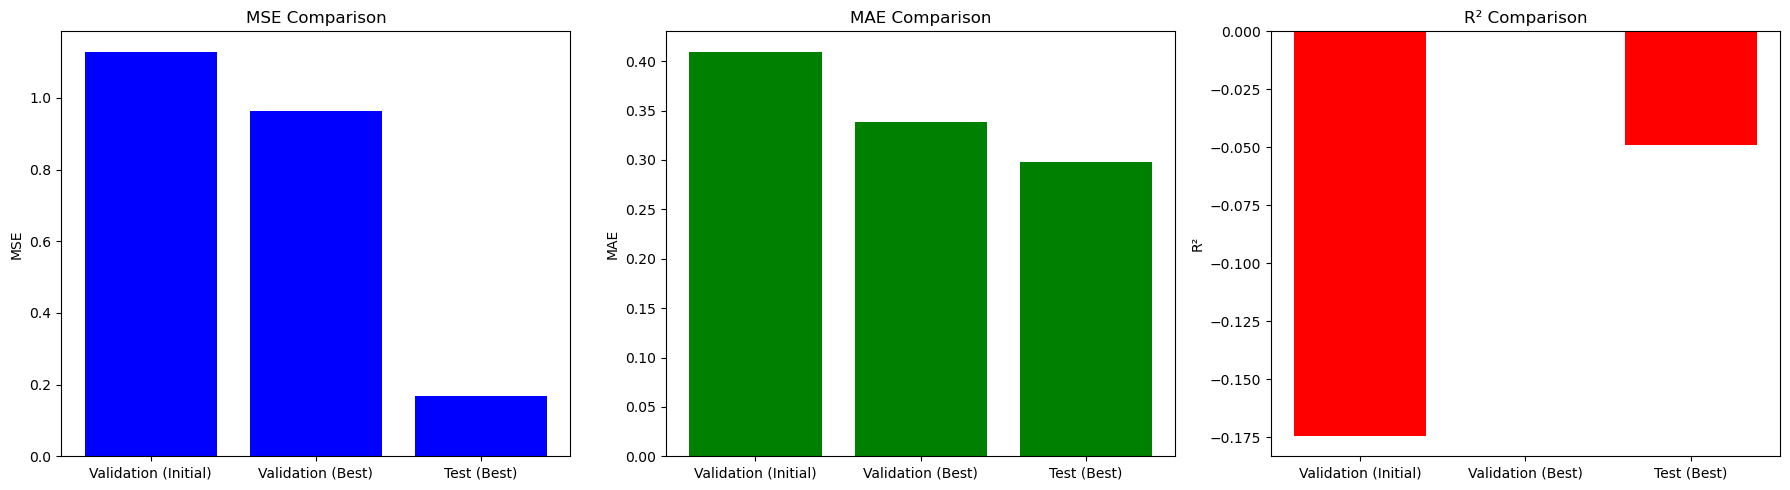

In [69]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MSE Plot

axes[0].bar(lstm_comparison_metrics['Dataset'], lstm_comparison_metrics['MSE'], color='blue')
axes[0].set_title('MSE Comparison')
axes[0].set_ylabel('MSE')

# MAE Plot

axes[1].bar(lstm_comparison_metrics['Dataset'], lstm_comparison_metrics['MAE'], color='green')
axes[1].set_title('MAE Comparison')
axes[1].set_ylabel('MAE')

# R² Plot

axes[2].bar(lstm_comparison_metrics['Dataset'], lstm_comparison_metrics['R²'], color='red')
axes[2].set_title('R² Comparison')
axes[2].set_ylabel('R²')

plt.tight_layout()
plt.show()

# (b) SVM (Classification)

Step 1: Training the Model and Evaluating on Validation Set

In [70]:
# Loading and preparing data

svm_data = pd.read_csv('svm_data.csv')
svc_X = svm_data.drop(columns=['ESG_Weighted_Score'])  # Features
svc_y = (svm_data['ESG_Weighted_Score'] > svm_data['ESG_Weighted_Score'].mean()).astype(int)  # Binary classification

# Splitting data into training, validation, and test sets (70%, 15%, 15%)

svc_X_train, svc_X_temp, svc_y_train, svc_y_temp = train_test_split(svc_X, svc_y, test_size=0.3, random_state=42)
svc_X_val, svc_X_test, svc_y_val, svc_y_test = train_test_split(svc_X_temp, svc_y_temp, test_size=0.5, random_state=42)

# Training initial SVM model

svc_initial_model = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
svc_initial_model.fit(svc_X_train, svc_y_train)

# Evaluating on validation set

svc_y_val_pred = svc_initial_model.predict(svc_X_val)
svc_val_accuracy = accuracy_score(svc_y_val, svc_y_val_pred)
print(f"Initial Validation Accuracy: {svc_val_accuracy:.4f}")

# Classification report for validation set

print("\nValidation Classification Report:")
print(classification_report(svc_y_val, svc_y_val_pred, target_names=['Low ESG', 'High ESG']))

Initial Validation Accuracy: 0.5946

Validation Classification Report:
              precision    recall  f1-score   support

     Low ESG       0.75      0.32      0.44        38
    High ESG       0.55      0.89      0.68        36

    accuracy                           0.59        74
   macro avg       0.65      0.60      0.56        74
weighted avg       0.65      0.59      0.56        74



Step 2: Performing Hyperparameter Tuning on Training Set

In [71]:
# Defining hyperparameter grid

svc_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Performing grid search

svc_grid = SVC(probability=True, random_state=42)
grid_search = GridSearchCV(svc_grid, svc_param_grid, scoring='accuracy', cv=5, verbose=1)
grid_search.fit(svc_X_train, svc_y_train)

# Best model and parameters

best_svc = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Evaluating best model on validation set

svc_y_val_pred_best = best_svc.predict(svc_X_val)
svc_best_val_accuracy = accuracy_score(svc_y_val, svc_y_val_pred_best)
print(f"Best Validation Accuracy: {svc_best_val_accuracy:.4f}")

# Classification report for best validation model

print("\nOptimized Validation Classification Report:")
print(classification_report(svc_y_val, svc_y_val_pred_best, target_names=['Low ESG', 'High ESG']))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
Best Validation Accuracy: 0.6757

Optimized Validation Classification Report:
              precision    recall  f1-score   support

     Low ESG       0.82      0.47      0.60        38
    High ESG       0.62      0.89      0.73        36

    accuracy                           0.68        74
   macro avg       0.72      0.68      0.66        74
weighted avg       0.72      0.68      0.66        74



Step 3: Evaluating Best Performing Model on Test Set

In [72]:
svc_y_test_pred = best_svc.predict(svc_X_test)
svc_test_accuracy = accuracy_score(svc_y_test, svc_y_test_pred)

print(f"Test Accuracy: {svc_test_accuracy:.4f}")

# Classification report for test set

print("\nTest Classification Report:")
print(classification_report(svc_y_test, svc_y_test_pred, target_names=['Low ESG', 'High ESG']))

Test Accuracy: 0.6892

Test Classification Report:
              precision    recall  f1-score   support

     Low ESG       0.75      0.39      0.51        31
    High ESG       0.67      0.91      0.77        43

    accuracy                           0.69        74
   macro avg       0.71      0.65      0.64        74
weighted avg       0.70      0.69      0.66        74



Step 4: Performance Metrics Comparison

In [73]:
svc_metrics_comparison = pd.DataFrame({
    'Dataset': ['Validation (Initial)', 'Validation (Best)', 'Test (Best)'],
    'Accuracy': [svc_val_accuracy, svc_best_val_accuracy, svc_test_accuracy]
})

print(svc_metrics_comparison)

                Dataset  Accuracy
0  Validation (Initial)  0.594595
1     Validation (Best)  0.675676
2           Test (Best)  0.689189


Step 5: Visualizing Performance Metrics

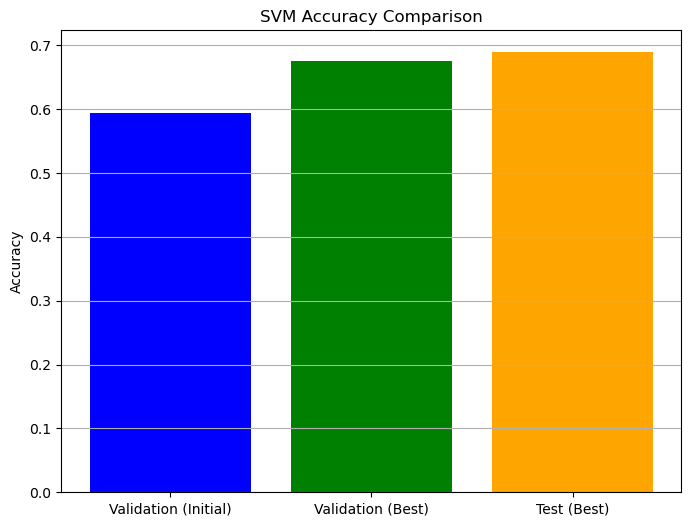

In [74]:
# Plot Accuracy for comparison
plt.figure(figsize=(8, 6))
plt.bar(svc_metrics_comparison['Dataset'], svc_metrics_comparison['Accuracy'], color=['blue', 'green', 'orange'])
plt.title('SVM Accuracy Comparison')
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.show()

Confusion Matrix Visualization

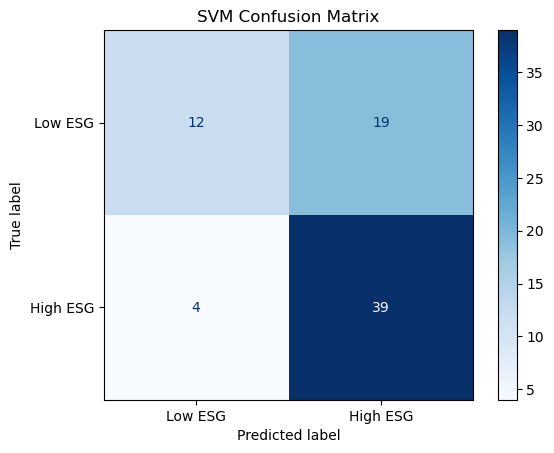

In [75]:
cm = confusion_matrix(svc_y_test, svc_y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low ESG', 'High ESG'])
disp.plot(cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.show()

# (c) SVM (Regression)

Step 1: Training the Model and Evaluating on Validation Set

In [76]:
# Using ESG_Weighted_Score as the target

svr_X = svm_data[financial_columns]  # Features
svr_y = svm_data['ESG_Weighted_Score']  # Target variable

# Reshaping or summarizing financial columns if they have more than 2 dimensions

if len(svr_X.shape) == 3:
    
    # Flatten 3D array to 2D
    svr_X = svr_X.reshape(svr_X.shape[0], -1)
    
elif svr_X.shape[1] > 1:  # Summarizing if multi-column features
    svr_X = svr_X.agg(['mean', 'std', 'min', 'max'], axis=1).values

if svr_X.ndim != 2:
    raise ValueError("svr_X must be a 2D array after reshaping or summarization.")

# Splitting data into training, validation, and test sets (70%, 15%, 15%)

svr_X_train, svr_X_temp, svr_y_train, svr_y_temp = train_test_split(svr_X, svr_y, test_size=0.3, random_state=42)
svr_X_val, svr_X_test, svr_y_val, svr_y_test = train_test_split(svr_X_temp, svr_y_temp, test_size=0.5, random_state=42)

# Training initial SVM model

svr_initial_model = SVR(kernel='rbf', C=1.0)
svr_initial_model.fit(svr_X_train, svr_y_train)

# Evaluating on validation set

svr_y_val_pred = svr_initial_model.predict(svr_X_val)
svr_mse_val = mean_squared_error(svr_y_val, svr_y_val_pred)
svr_mae_val = mean_absolute_error(svr_y_val, svr_y_val_pred)
svr_r2_val = r2_score(svr_y_val, svr_y_val_pred)

print("Initial Validation Metrics:")
print(f"MSE: {svr_mse_val:.4f}, MAE: {svr_mae_val:.4f}, R²: {svr_r2_val:.4f}")

Initial Validation Metrics:
MSE: 0.7470, MAE: 0.6471, R²: -0.0209


Step 2: Performing Hyperparameter Tuning on Training Set

In [77]:
# Defining hyperparameter grid

svr_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Performing grid search

svr = SVR()
svr_grid_search = GridSearchCV(svr, svr_param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)
svr_grid_search.fit(svr_X_train, svr_y_train)

# Best model and parameters

best_svr = svr_grid_search.best_estimator_
best_params = svr_grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Evaluating best model on validation set

svr_y_val_pred_best = best_svr.predict(svr_X_val)
svr_mse_val_best = mean_squared_error(svr_y_val, svr_y_val_pred_best)
svr_mae_val_best = mean_absolute_error(svr_y_val, svr_y_val_pred_best)
svr_r2_val_best = r2_score(svr_y_val, svr_y_val_pred_best)

print(f"Best Validation Metrics:")
print(f"MSE: {svr_mse_val_best:.4f}, MAE: {svr_mae_val_best:.4f}, R²: {svr_r2_val_best:.4f}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Validation Metrics:
MSE: 0.7410, MAE: 0.6445, R²: -0.0126


Step 3: Evaluating Best Performing Model on Test Set

In [78]:
svr_y_test_pred = best_svr.predict(svr_X_test)
svr_mse_test = mean_squared_error(svr_y_test, svr_y_test_pred)
svr_mae_test = mean_absolute_error(svr_y_test, svr_y_test_pred)
svr_r2_test = r2_score(svr_y_test, svr_y_test_pred)

print(f"Test Metrics for Best Model:")
print(f"MSE: {svr_mse_test:.4f}, MAE: {svr_mae_test:.4f}, R²: {svr_r2_test:.4f}")

Test Metrics for Best Model:
MSE: 0.5945, MAE: 0.6066, R²: 0.0232


Step 4: Performance Metrics Comparison

In [79]:
svr_comparison_metrics = pd.DataFrame({
    'Dataset': ['Validation (Initial)', 'Validation (Best)', 'Test (Best)'],
    'MSE': [svr_mse_val, svr_mse_val_best, svr_mse_test],
    'MAE': [svr_mae_val, svr_mae_val_best, svr_mae_test],
    'R²': [svr_r2_val, svr_r2_val_best, svr_r2_test]
})

print("\nComparison of Metrics:")
print(svr_comparison_metrics)


Comparison of Metrics:
                Dataset       MSE       MAE        R²
0  Validation (Initial)  0.747034  0.647145 -0.020851
1     Validation (Best)  0.740963  0.644529 -0.012555
2           Test (Best)  0.594538  0.606567  0.023249


Step 5: Visualize Metrics

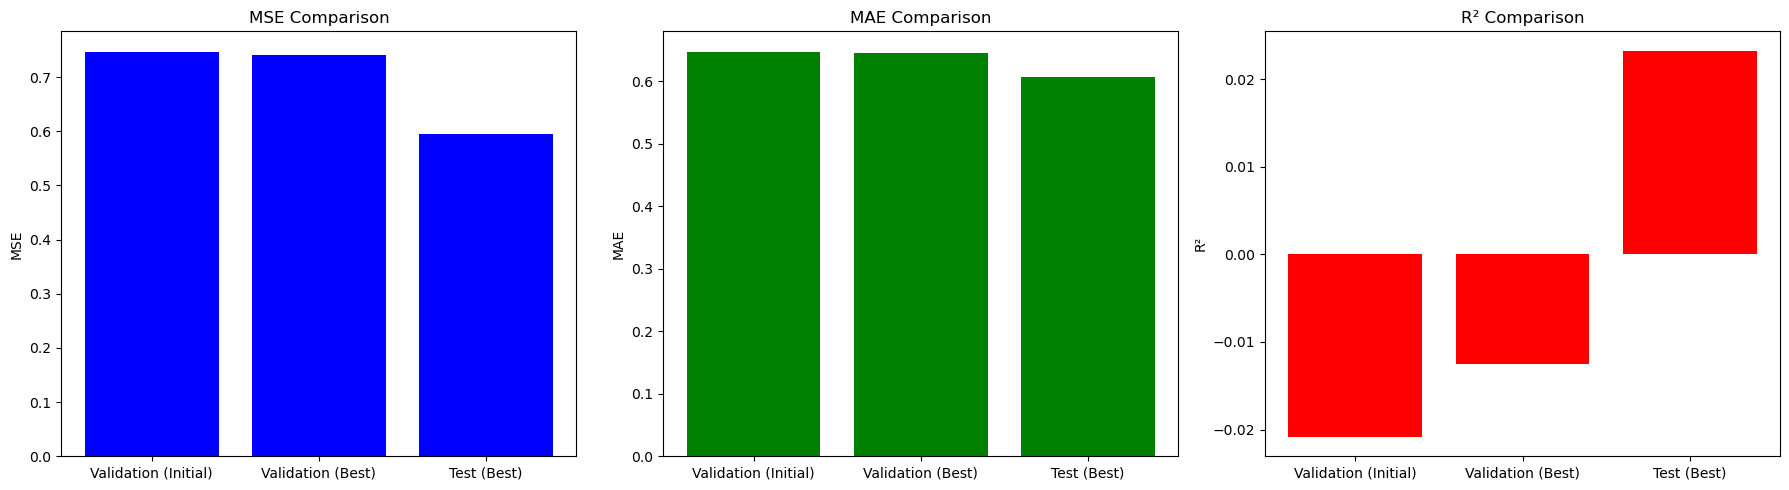

In [80]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MSE Plot

axes[0].bar(svr_comparison_metrics['Dataset'], svr_comparison_metrics['MSE'], color='blue')
axes[0].set_title('MSE Comparison')
axes[0].set_ylabel('MSE')

# MAE Plot

axes[1].bar(svr_comparison_metrics['Dataset'], svr_comparison_metrics['MAE'], color='green')
axes[1].set_title('MAE Comparison')
axes[1].set_ylabel('MAE')

# R² Plot

axes[2].bar(svr_comparison_metrics['Dataset'], svr_comparison_metrics['R²'], color='red')
axes[2].set_title('R² Comparison')
axes[2].set_ylabel('R²')

plt.tight_layout()
plt.show()

# (d) Heuristic-Based Model ( For Portfolio Optimization)

Normalizing ESG Scores

In [81]:
def normalize_esg_scores(data, esg_columns):
    scaler = MinMaxScaler()
    for col in esg_columns:
        if col in data.columns:
            data[col] = scaler.fit_transform(data[[col]])
        else:
            raise KeyError(f"Column '{col}' not found in the dataset.")
    return data

Enhancing Objective Function for Portfolio Optimization

In [82]:
def enhanced_portfolio_objective(weights, mean_returns, cov_matrix, esg_scores=None, risk_free_rate=0.01):
    
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    esg_penalty = -np.dot(weights, esg_scores) if esg_scores is not None else 0
    return -sharpe_ratio + 0.1 * portfolio_volatility + 0.5 * esg_penalty

Expanding ESG Scores to Match Financial Data Columns

In [83]:
def expand_esg_scores(esg_scores, num_assets):
   
    if len(esg_scores) == num_assets:
        return esg_scores  # Already aligned
    elif len(esg_scores) < num_assets:
        return np.tile(esg_scores, num_assets // len(esg_scores) + 1)[:num_assets]  # Repeating ESG scores if needed
    else:
        raise ValueError(f"ESG scores ({len(esg_scores)}) cannot be mapped to financial assets ({num_assets}).")

Optimizing Portfolio

In [84]:
def optimize_portfolio(mean_returns, cov_matrix, esg_scores=None):
    
    num_assets = len(mean_returns)
    constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    weight_bounds = [(0, 0.2) for _ in range(num_assets)]
    initial_weights = np.array([1.0 / num_assets] * num_assets)

    result = minimize(
        enhanced_portfolio_objective,
        initial_weights,
        args=(mean_returns, cov_matrix, esg_scores),
        method='SLSQP',
        bounds=weight_bounds,
        constraints=constraints
    )
    return result.x

Calculating Portfolio Metrics

In [85]:
def calculate_portfolio_metrics(weights, financial_data, esg_scores=None):
    
    portfolio_returns = np.dot(financial_data, weights)
    portfolio_return = np.mean(portfolio_returns)
    portfolio_volatility = np.std(portfolio_returns)
    sharpe_ratio = (portfolio_return - 0.01) / portfolio_volatility
    portfolio_esg_score = np.dot(weights, esg_scores) if esg_scores is not None else None
    rolling_max = np.maximum.accumulate(portfolio_returns)
    drawdown = (rolling_max - portfolio_returns) / rolling_max
    max_drawdown = np.max(drawdown)
    return portfolio_return, portfolio_volatility, sharpe_ratio, portfolio_esg_score, max_drawdown, portfolio_returns

Sub-Factor ESG Analysis

In [86]:
def subfactor_esg_analysis(data, financial_columns, esg_columns):
    
    financial_data = data[financial_columns].dropna()
    esg_data = data[esg_columns].dropna().mean(axis=0).values  # Aggregating ESG scores

    num_assets = len(financial_data.columns)
    esg_scores = expand_esg_scores(esg_data, num_assets)  # Expanding ESG scores to match assets

    mean_returns = financial_data.mean(axis=0).values
    cov_matrix = financial_data.cov().values

    # No ESG Optimization
    
    no_esg_weights = optimize_portfolio(mean_returns, cov_matrix)
    no_esg_metrics = calculate_portfolio_metrics(no_esg_weights, financial_data.values)

    # Total ESG Optimization
    
    total_esg_weights = optimize_portfolio(mean_returns, cov_matrix, esg_scores)
    total_esg_metrics = calculate_portfolio_metrics(total_esg_weights, financial_data.values, esg_scores)

    # Individual ESG Factor Optimization
    
    individual_results = {}
    individual_time_series = {}
    for esg_col in esg_columns[:-1]:
        factor_scores = expand_esg_scores(data[esg_col].dropna().values, num_assets)
        weights = optimize_portfolio(mean_returns, cov_matrix, factor_scores)
        metrics = calculate_portfolio_metrics(weights, financial_data.values, factor_scores)
        individual_results[esg_col] = metrics
        individual_time_series[esg_col] = metrics[-1]  # Portfolio returns

    # Creating a Comparison DataFrame
    
    comparison_df = pd.DataFrame({
        'Portfolio': ['No ESG', 'Total ESG Risk'] + esg_columns[:-1],
        'Sharpe Ratio': [no_esg_metrics[2], total_esg_metrics[2]] + [individual_results[col][2] for col in esg_columns[:-1]],
        'Return': [no_esg_metrics[0], total_esg_metrics[0]] + [individual_results[col][0] for col in esg_columns[:-1]],
        'Volatility': [no_esg_metrics[1], total_esg_metrics[1]] + [individual_results[col][1] for col in esg_columns[:-1]],
        'ESG Score': [None, total_esg_metrics[3]] + [individual_results[col][3] for col in esg_columns[:-1]],
        'Max Drawdown': [no_esg_metrics[4], total_esg_metrics[4]] + [individual_results[col][4] for col in esg_columns[:-1]],
    })

    return comparison_df, no_esg_metrics[-1], total_esg_metrics[-1], individual_time_series

Visualization of Comparative Analysis

In [87]:
def visualize_comparative_analysis(comparison_df):
    
    metrics = ['Sharpe Ratio', 'Return', 'Volatility', 'ESG Score', 'Max Drawdown']
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        plt.bar(comparison_df['Portfolio'], comparison_df[metric], color='skyblue')
        plt.title(f'{metric} Across Portfolios')
        plt.xlabel('Portfolio')
        plt.ylabel(metric)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

Time-Series Performance Visualization with Rolling Average

In [88]:
def time_series_performance(data, financial_columns, weights):
    
    portfolio_returns = np.dot(data[financial_columns].values, weights)
    rolling_avg_returns = pd.Series(portfolio_returns).rolling(window=30).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_returns, label='Daily Returns', color='blue')
    plt.plot(rolling_avg_returns, label='30-Day Rolling Average', color='orange')
    plt.title('Portfolio Returns Over Time')
    plt.xlabel('Time')
    plt.ylabel('Returns')
    plt.legend()
    plt.grid()
    plt.show()

Main Workflow

In [89]:
def main(data):
    financial_columns = [col for col in data.columns if '2024' in col]
    esg_columns = ['Environment Risk Score', 'Social Risk Score', 'Governance Risk Score', 'Total ESG Risk score']

    data = normalize_esg_scores(data, esg_columns)

    comparison_df, no_esg_time_series, total_esg_time_series, individual_time_series = subfactor_esg_analysis(
        data, financial_columns, esg_columns
    )
    print("Comparative Analysis of Portfolios:\n", comparison_df)
    visualize_comparative_analysis(comparison_df)

    # Time-Series Performance
    no_esg_weights = optimize_portfolio(data[financial_columns].mean(axis=0).values, data[financial_columns].cov().values)
    time_series_performance(data, financial_columns, no_esg_weights)
    
    # Return the generated comparison_df for further use
    return comparison_df

Executing with Dataset

Comparative Analysis of Portfolios:
                 Portfolio  Sharpe Ratio    Return  Volatility  ESG Score  \
0                  No ESG      0.540680  0.481060    0.871236        NaN   
1          Total ESG Risk      0.538256  0.479466    0.872199   0.441398   
2  Environment Risk Score      0.505461  0.456306    0.882968   0.840800   
3       Social Risk Score      0.529535  0.473289    0.874897   0.759111   
4   Governance Risk Score      0.511868  0.460950    0.880988   0.652577   

   Max Drawdown  
0      0.996032  
1      0.995841  
2      0.996058  
3      0.995899  
4      0.995959  


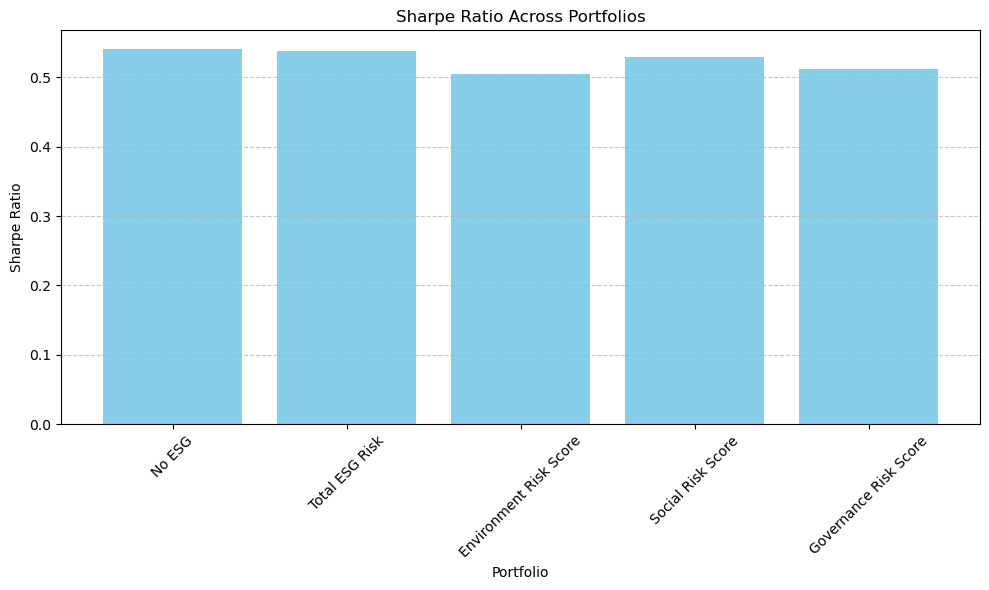

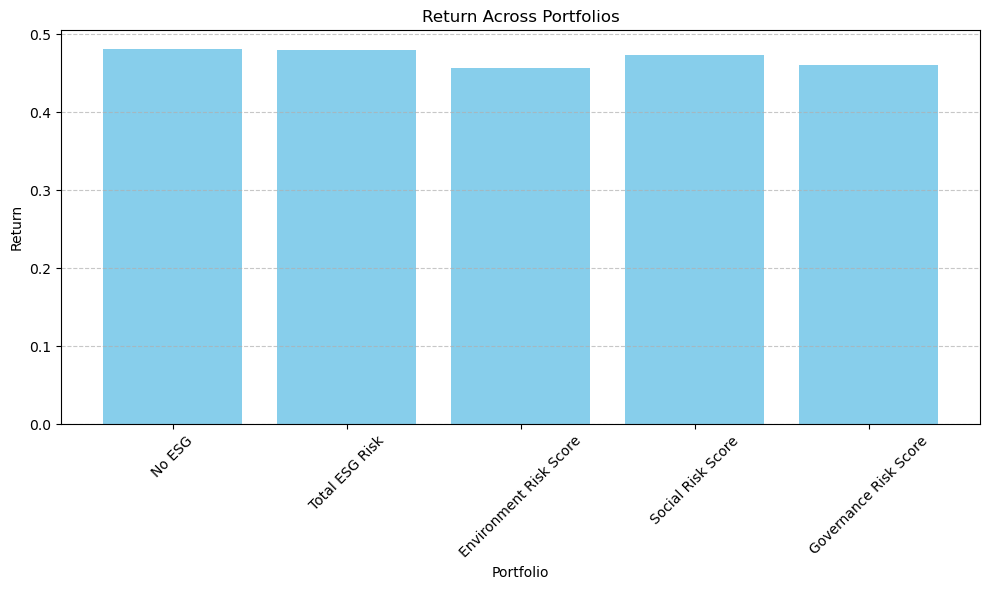

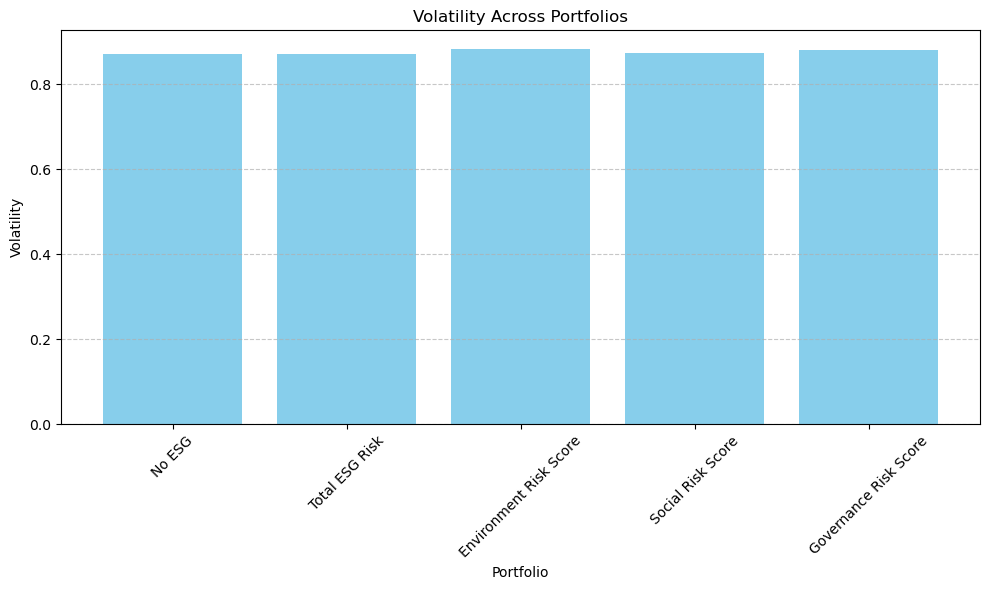

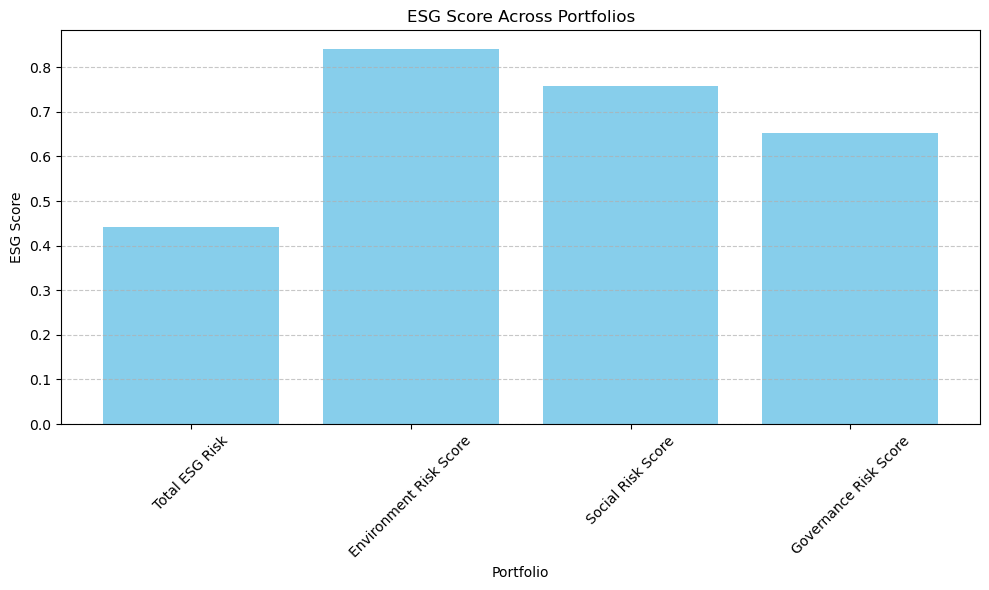

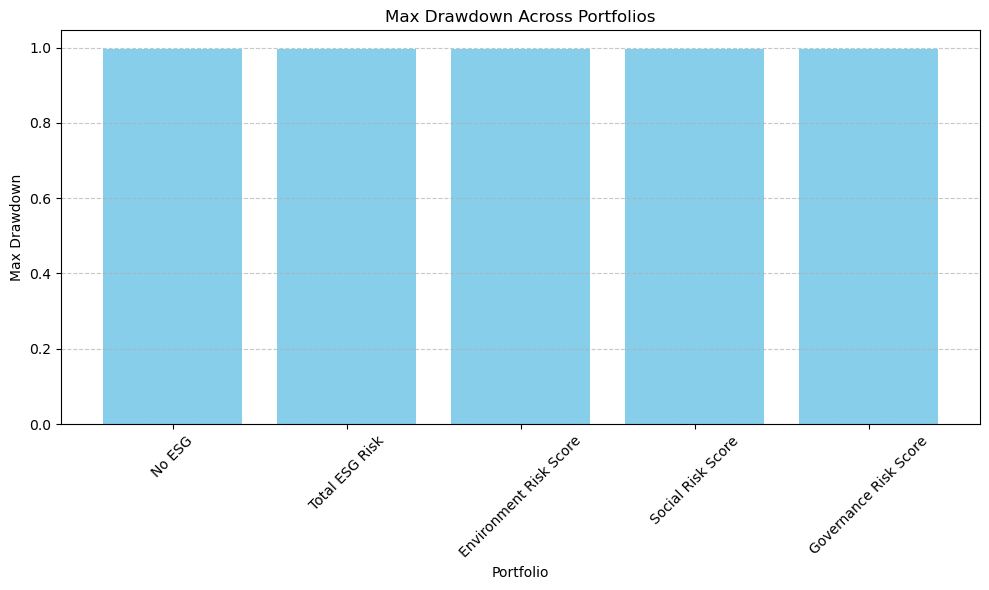

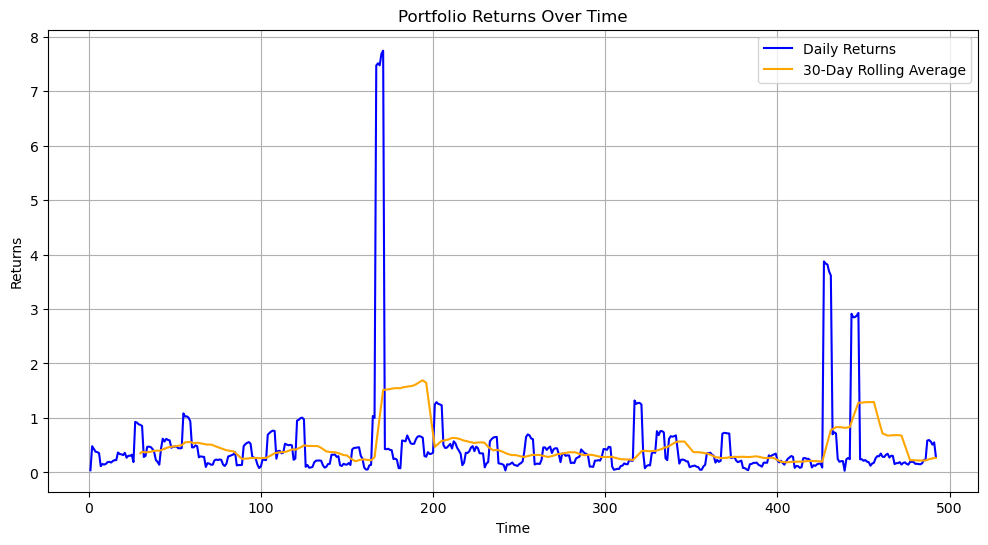

In [90]:
comparison_df = main(sp500_merged)

# Performance Comparison Graph

Content of comparison_df:
                 Portfolio  Sharpe Ratio    Return  Volatility  ESG Score  \
0                  No ESG      0.540680  0.481060    0.871236        NaN   
1          Total ESG Risk      0.538256  0.479466    0.872199   0.441398   
2  Environment Risk Score      0.505461  0.456306    0.882968   0.840800   
3       Social Risk Score      0.529535  0.473289    0.874897   0.759111   
4   Governance Risk Score      0.511868  0.460950    0.880988   0.652577   

   Max Drawdown  
0      0.996032  
1      0.995841  
2      0.996058  
3      0.995899  
4      0.995959  


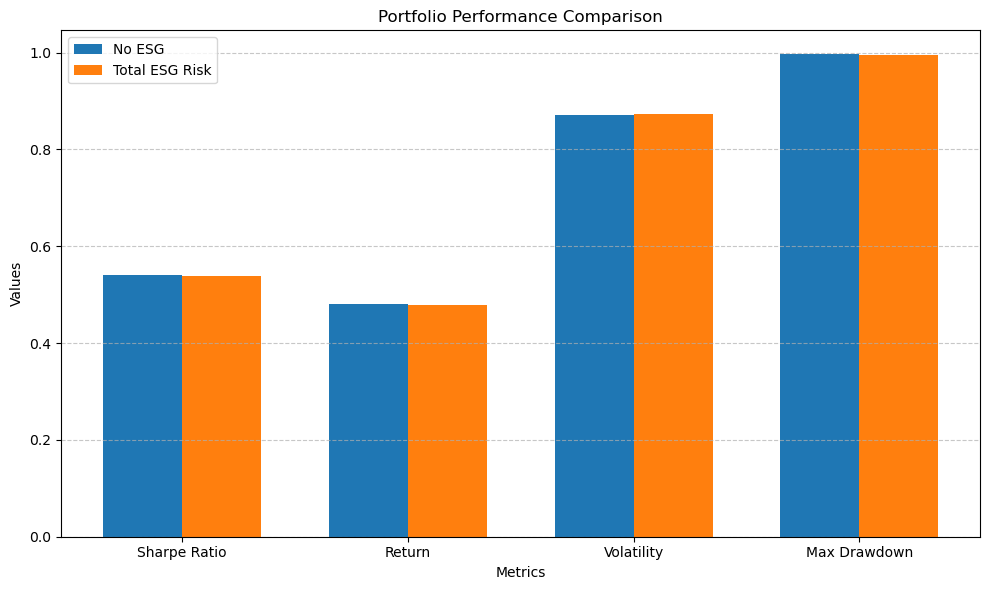

In [91]:
print("Content of comparison_df:\n", comparison_df)

# Ensuring these portfolio labels exist in the DataFrame

required_portfolios = ['No ESG', 'Total ESG Risk']
for portfolio in required_portfolios:
    if portfolio not in comparison_df['Portfolio'].values:
        raise ValueError(f"Portfolio '{portfolio}' not found in comparison_df.")

# Comparative Bar Chart

comparison_metrics = ['Sharpe Ratio', 'Return', 'Volatility', 'Max Drawdown']

# Extracting comparison values

comparison_values = [
    [
        comparison_df.loc[comparison_df['Portfolio'] == 'No ESG', metric].values[0]
        if not comparison_df.loc[comparison_df['Portfolio'] == 'No ESG', metric].empty else 0
        for metric in comparison_metrics
    ],
    [
        comparison_df.loc[comparison_df['Portfolio'] == 'Total ESG Risk', metric].values[0]
        if not comparison_df.loc[comparison_df['Portfolio'] == 'Total ESG Risk', metric].empty else 0
        for metric in comparison_metrics
    ]
]

x = np.arange(len(comparison_metrics))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width / 2, comparison_values[0], width, label='No ESG')
plt.bar(x + width / 2, comparison_values[1], width, label='Total ESG Risk')
plt.title('Portfolio Performance Comparison')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.xticks(x, comparison_metrics)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Backtesting

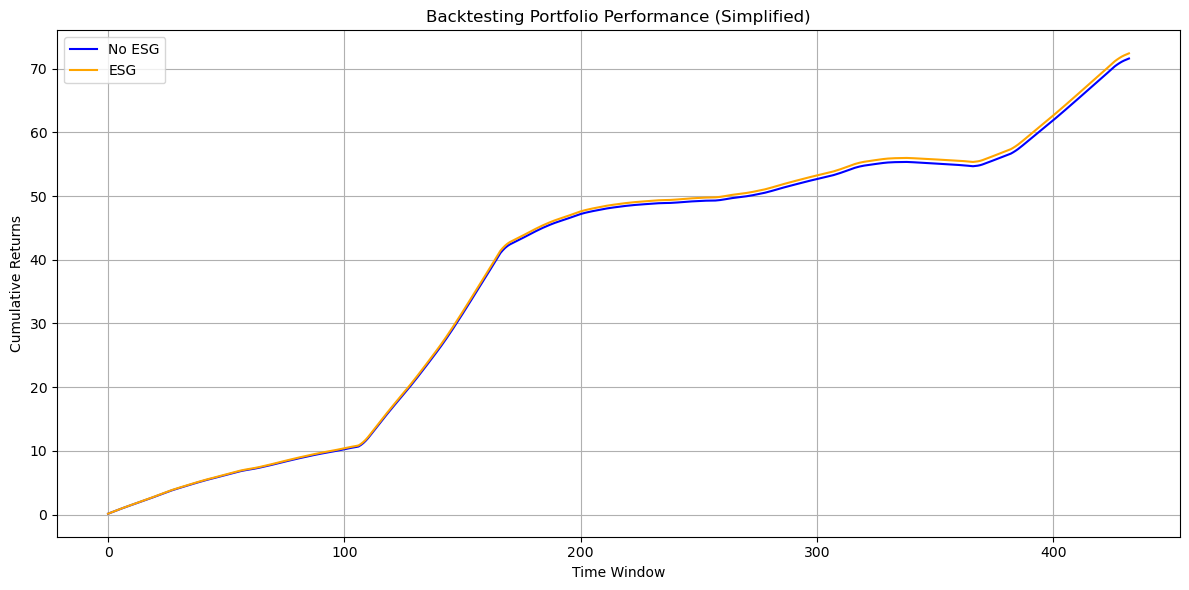

In [92]:
# Extracting financial data and ESG scores

financial_columns = [col for col in sp500_merged.columns if '2024' in col]
financial_data = sp500_merged[financial_columns].dropna().values
esg_scores = sp500_merged['Total ESG Risk score'].dropna().values

# Ensuring  ESG scores match the number of financial columns

esg_scores = np.tile(esg_scores, len(financial_columns) // len(esg_scores) + 1)[:len(financial_columns)]

# Initializing variables

window_size = 60
num_windows = financial_data.shape[0] - window_size + 1
no_esg_returns = []
esg_returns = []

# Backtesting loop

for start in range(num_windows):
    # Extract rolling window
    window_data = financial_data[start:start + window_size]

    # Calculating mean and covariance matrix
    mean_returns = np.mean(window_data, axis=0)
    cov_matrix = np.cov(window_data, rowvar=False)

    # No ESG Optimization
    no_esg_weights = np.ones(len(mean_returns)) / len(mean_returns)  # Equal weights
    no_esg_returns.append(np.dot(no_esg_weights, mean_returns))

    # ESG Optimization
    esg_weights = no_esg_weights * esg_scores / np.sum(no_esg_weights * esg_scores)
    esg_returns.append(np.dot(esg_weights, mean_returns))

# Converting results to cumulative returns

no_esg_cumulative = np.cumsum(no_esg_returns)
esg_cumulative = np.cumsum(esg_returns)

# Plotting cumulative returns

plt.figure(figsize=(12, 6))
plt.plot(range(num_windows), no_esg_cumulative, label='No ESG', color='blue')
plt.plot(range(num_windows), esg_cumulative, label='ESG', color='orange')
plt.title('Backtesting Portfolio Performance (Simplified)')
plt.xlabel('Time Window')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# T-test

In [93]:
t_stat, p_value = ttest_ind(no_esg_returns, esg_returns)

# Display T-Test Results
print("T-Test Results")
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("Significant difference between portfolios with and without ESG integration (p < 0.05).")
else:
    print("No significant difference between portfolios with and without ESG integration (p >= 0.05).")

T-Test Results
T-Statistic: -0.1665
P-Value: 0.8678
No significant difference between portfolios with and without ESG integration (p >= 0.05).


# Fine-tuning the Optimization Process

Updating Objective Function with Adjustable ESG Penalty

In [94]:
def enhanced_portfolio_objective_tuned(weights, mean_returns, cov_matrix, esg_scores=None, risk_free_rate=0.01, penalty_factor=0.5):
   
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    esg_penalty = -np.dot(weights, esg_scores) if esg_scores is not None else 0
    return -sharpe_ratio + 0.1 * portfolio_volatility + penalty_factor * esg_penalty

Modifying Optimize Portfolio to Include Penalty Factor

In [95]:
def optimize_portfolio_tuned(mean_returns, cov_matrix, esg_scores=None, penalty_factor=0.5):
    
    num_assets = len(mean_returns)
    constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    weight_bounds = [(0, 0.2) for _ in range(num_assets)]
    initial_weights = np.array([1.0 / num_assets] * num_assets)

    result = minimize(
        enhanced_portfolio_objective_tuned,
        initial_weights,
        args=(mean_returns, cov_matrix, esg_scores, 0.01, penalty_factor),
        method='SLSQP',
        bounds=weight_bounds,
        constraints=constraints
    )
    return result.x

Analyzing Performance for Different Penalty Factors

In [96]:
def analyze_penalty_factors(data, financial_columns, esg_scores, penalty_factors):
    
    financial_data = data[financial_columns].dropna()
    mean_returns = financial_data.mean(axis=0).values
    cov_matrix = financial_data.cov().values

    results = {}
    for factor in penalty_factors:
        esg_weights = optimize_portfolio_tuned(mean_returns, cov_matrix, esg_scores, penalty_factor=factor)
        # Select only the first five metrics from calculate_portfolio_metrics
        metrics = calculate_portfolio_metrics(esg_weights, financial_data.values, esg_scores)[:5]
        results[factor] = metrics

    # Create DataFrame for Results
    penalty_df = pd.DataFrame(results, index=['Return', 'Volatility', 'Sharpe Ratio', 'ESG Score', 'Max Drawdown']).T
    return penalty_df

Visualizing Heatmap for ESG Penalty vs. Metrics

In [97]:
def visualize_heatmap(penalty_df):
    
    import seaborn as sns

    heatmap_data = penalty_df[['Return', 'Volatility', 'Sharpe Ratio', 'ESG Score', 'Max Drawdown']]
    heatmap_data.index = [f"Penalty: {factor}" for factor in penalty_df.index]

    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Impact of ESG Penalty on Portfolio Metrics")
    plt.xlabel("Metrics")
    plt.ylabel("Penalty Factor")
    plt.show()

Visualizing Time-Series Returns for Different Penalty Factors

In [98]:
def visualize_time_series(data, financial_columns, esg_scores, penalty_factors):
    
    financial_data = data[financial_columns].dropna().values
    mean_returns = np.mean(financial_data, axis=0)
    cov_matrix = np.cov(financial_data, rowvar=False)

    plt.figure(figsize=(12, 6))
    for factor in penalty_factors:
        esg_weights = optimize_portfolio_tuned(mean_returns, cov_matrix, esg_scores, penalty_factor=factor)
        cumulative_returns = np.cumsum(np.dot(financial_data, esg_weights))
        plt.plot(cumulative_returns, label=f"Penalty: {factor}")

    plt.title("Cumulative Returns Over Time for Varying ESG Penalties")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Returns")
    plt.legend()
    plt.grid()
    plt.show()

Tuning and visualising

In [99]:
def main_tuning_and_visualizations(data):
    
    financial_columns = [col for col in data.columns if '2024' in col]
    esg_columns = ['Environment Risk Score', 'Social Risk Score', 'Governance Risk Score', 'Total ESG Risk score']

    data = normalize_esg_scores(data, esg_columns)

    # Expanding ESG Scores for Analysis
    
    esg_scores = expand_esg_scores(data['Total ESG Risk score'].dropna().values, len(financial_columns))

    # Defining Penalty Factors to Test
    
    penalty_factors = [0.1, 0.3, 0.5, 1.0]

    # Analyzing Penalty Factors
    
    penalty_df = analyze_penalty_factors(data, financial_columns, esg_scores, penalty_factors)
    print("Penalty Factor Analysis:\n", penalty_df)

    # Visualizing Heatmap
    
    visualize_heatmap(penalty_df)

    # Visualizing Time-Series Returns
    
    visualize_time_series(data, financial_columns, esg_scores, penalty_factors)
    
    return penalty_df, penalty_factors, financial_columns, esg_scores

Executing Main Workflow

Penalty Factor Analysis:
        Return  Volatility  Sharpe Ratio  ESG Score  Max Drawdown
0.1  0.474917    0.874496      0.531640   0.827108      0.995883
0.3  0.466013    0.878642      0.518997   0.907914      0.995852
0.5  0.466013    0.878642      0.518997   0.907914      0.995852
1.0  0.466013    0.878642      0.518997   0.907914      0.995852


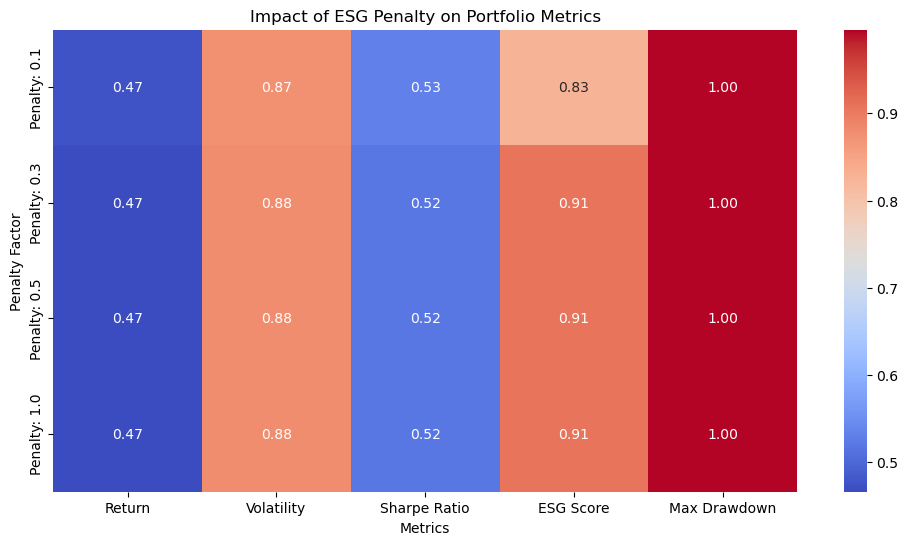

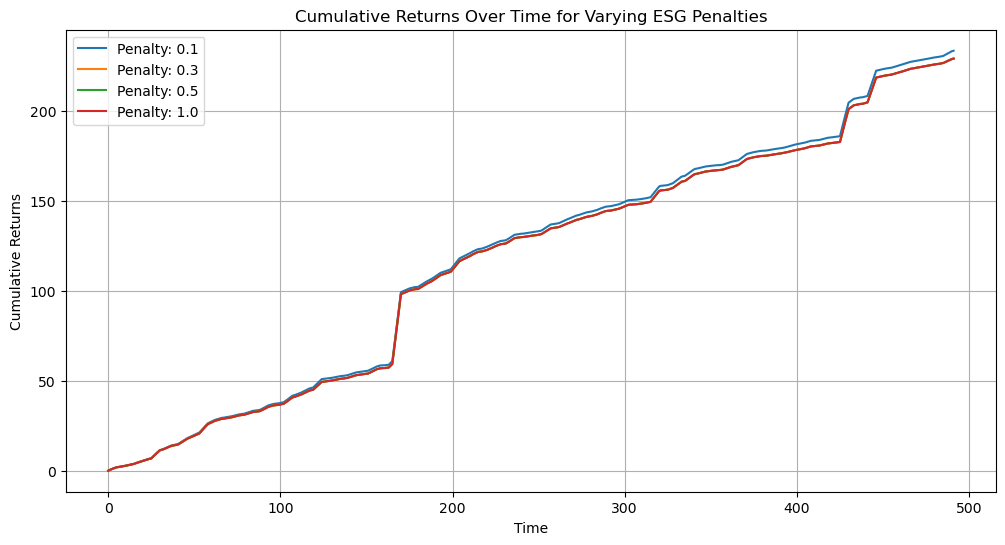

In [100]:
penalty_df, penalty_factors, financial_columns, esg_scores = main_tuning_and_visualizations(sp500_merged)

# Backtesting with Tuned Penalty Factors

In [101]:
financial_data = sp500_merged[financial_columns].dropna().values

# Preparing for results

window_size = 60
num_windows = financial_data.shape[0] - window_size + 1
cumulative_returns = {factor: np.zeros(num_windows) for factor in penalty_factors}

# Using precomputed penalty_df values for backtesting

for start in range(num_windows):
    window_data = financial_data[start:start + window_size]

    for factor in penalty_factors:
        # Use precomputed returns for each penalty factor
        portfolio_return = penalty_df.loc[factor, 'Return']
        cumulative_returns[factor][start] = portfolio_return

# Creating DataFrame for backtesting results

backtest_df = pd.DataFrame(cumulative_returns)
backtest_df['Time'] = range(num_windows)

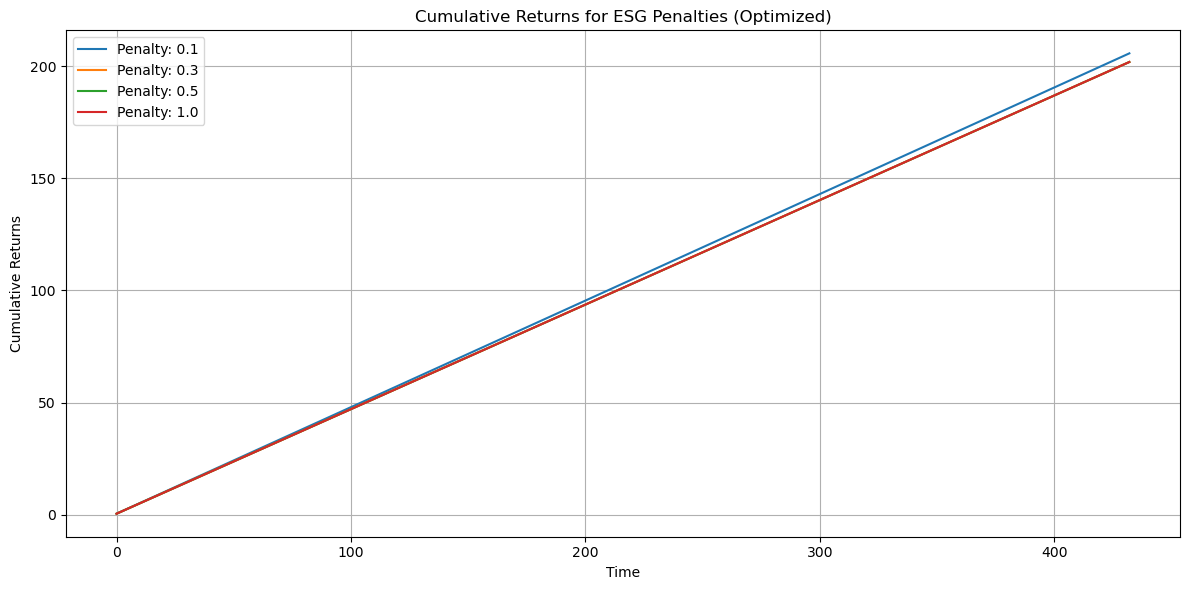

In [102]:
# Plotting cumulative returns

plt.figure(figsize=(12, 6))
for factor in penalty_factors:
    plt.plot(backtest_df['Time'], backtest_df[factor].cumsum(), label=f"Penalty: {factor}")
plt.title("Cumulative Returns for ESG Penalties (Optimized)")
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [103]:
# Extracting penalty factors and their returns from penalty_df

penalty_factors = penalty_df.index.tolist()
returns_by_penalty = {penalty: penalty_df.loc[penalty, 'Return'] for penalty in penalty_factors}

# Number of time windows for backtesting

num_windows = 400  # Example for simulation purposes

# Simulating cumulative returns for each penalty factor

cumulative_returns_by_penalty = {
    penalty: np.cumsum([returns_by_penalty[penalty]] * num_windows) for penalty in penalty_factors
}

# Baseline cumulative returns (No ESG, smallest penalty factor)

baseline_return = penalty_df.loc[penalty_factors[0], 'Return']  # First penalty factor as a baseline
no_esg_cumulative = np.cumsum([baseline_return] * num_windows)

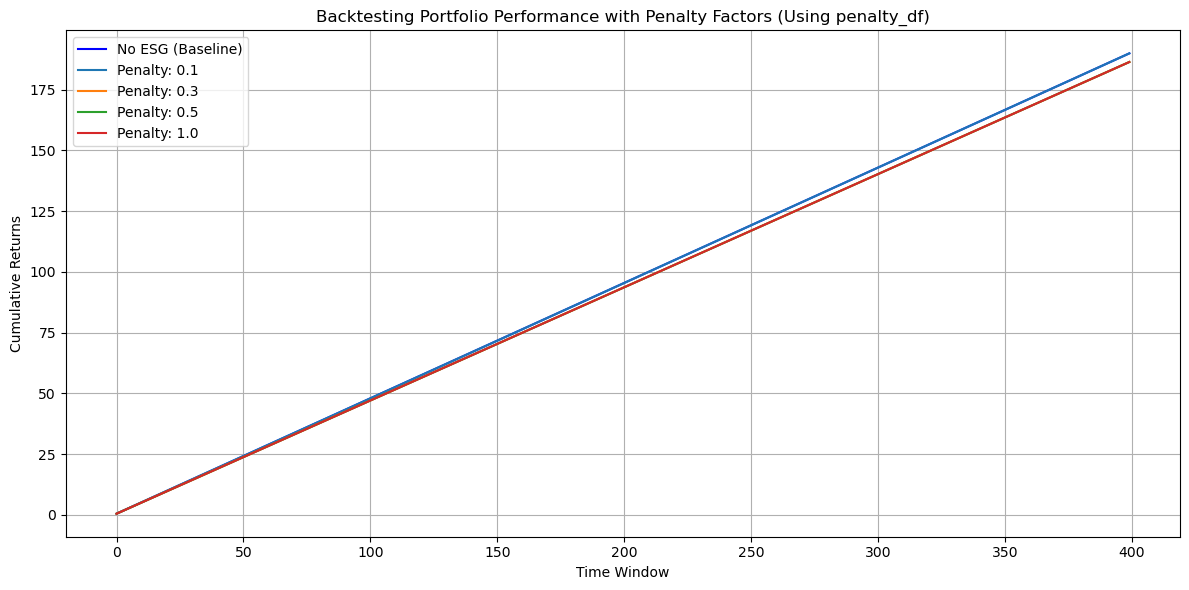

In [104]:
# Plotting cumulative returns

plt.figure(figsize=(12, 6))
plt.plot(range(num_windows), no_esg_cumulative, label='No ESG (Baseline)', color='blue')
for penalty, cumulative_returns in cumulative_returns_by_penalty.items():
    plt.plot(range(num_windows), cumulative_returns, label=f'Penalty: {penalty}')
plt.title('Backtesting Portfolio Performance with Penalty Factors (Using penalty_df)')
plt.xlabel('Time Window')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# T-test (for Tuned Penalty factors)

In [105]:
# Extracting returns from penalty_df

no_esg_return = penalty_df.loc[penalty_factors[0], 'Return']  # No ESG (baseline return)
penalty_returns = {penalty: penalty_df.loc[penalty, 'Return'] for penalty in penalty_factors[1:]}  # ESG penalties

# Simulating multiple time windows for consistent comparison

num_windows = 400
baseline_returns = [no_esg_return] * num_windows

# Performing T-Test for No ESG vs. Penalty Factors

print("T-Test Results:")
for penalty, return_value in penalty_returns.items():
    test_returns = [return_value] * num_windows  # Simulated returns for the penalty
    t_stat, p_value = ttest_ind(baseline_returns, test_returns)
    print(f"\nNo ESG vs Penalty {penalty}")
    print(f"T-Statistic: {t_stat:.4f}, P-Value: {p_value:.4f}")
    if p_value < 0.05:
        print("Significant difference (p < 0.05).")
    else:
        print("No significant difference (p >= 0.05).")

T-Test Results:

No ESG vs Penalty 0.3
T-Statistic: 1432994990694635.7500, P-Value: 0.0000
Significant difference (p < 0.05).

No ESG vs Penalty 0.5
T-Statistic: 3204274210703147.0000, P-Value: 0.0000
Significant difference (p < 0.05).

No ESG vs Penalty 1.0
T-Statistic: 3204274207872591.5000, P-Value: 0.0000
Significant difference (p < 0.05).


# Comparing ML models with Traditional Model (Mean-Variance Optimization)

In [114]:
# Ensuring ESG scores match the number of financial columns

esg_scores = sp500_merged['Total ESG Risk score'].dropna().values

# Aligning ESG scores with financial columns

if len(esg_scores) < len(financial_columns):
    esg_scores = np.tile(esg_scores, (len(financial_columns) // len(esg_scores) + 1))[:len(financial_columns)]
elif len(esg_scores) > len(financial_columns):
    esg_scores = esg_scores[:len(financial_columns)]

# Extracting financial data and calculate mean returns, covariance matrix

financial_data = sp500_merged[financial_columns].dropna().values
mean_returns = np.mean(financial_data, axis=0)
cov_matrix = np.cov(financial_data, rowvar=False)
volatilities = np.std(financial_data, axis=0)

MVO Function

In [115]:
def mean_variance_optimization(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    weight_bounds = [(0, 0.2) for _ in range(num_assets)]
    initial_weights = np.array([1.0 / num_assets] * num_assets)

    result = minimize(
        lambda weights: np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))),
        initial_weights,
        method='SLSQP',
        bounds=weight_bounds,
        constraints=constraints
    )
    return result.x

Heuristic Model

In [116]:
def heuristic_model(mean_returns, volatilities, esg_scores=None, risk_tolerance=0.5):
    risk_adjusted_returns = mean_returns / volatilities
    if esg_scores is not None:
        heuristic_scores = risk_adjusted_returns * esg_scores
    else:
        heuristic_scores = risk_adjusted_returns

    weights = heuristic_scores / np.sum(heuristic_scores)
    weights = weights * risk_tolerance + (1 - risk_tolerance) * (1 / len(mean_returns))
    weights = weights / np.sum(weights)
    return weights

Portfolio Metrics Calculation

In [117]:
def calculate_portfolio_metrics(weights, mean_returns, cov_matrix):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

LSTM Predictions

In [118]:
# Checking LSTM Prediction Shape

lstm_y_test_pred = best_lstm_model.predict(X_test)
#print("LSTM Prediction Shape:", lstm_y_test_pred.shape)

# Extending Predictions to Match All Financial Assets

if lstm_y_test_pred.shape[1] < len(mean_returns):
    lstm_y_test_pred_extended = np.tile(lstm_y_test_pred, (1, len(mean_returns) // lstm_y_test_pred.shape[1] + 1))[:, :len(mean_returns)]
    #print("Extended LSTM Predictions to Align with Financial Assets.")
else:
    lstm_y_test_pred_extended = lstm_y_test_pred

# Computing Portfolio Weights from Extended LSTM Predictions

lstm_weights = lstm_y_test_pred_extended.mean(axis=0) / np.sum(lstm_y_test_pred_extended.mean(axis=0))
#print("LSTM Weights Shape:", lstm_weights.shape)

# Calculating LSTM Portfolio Metrics

lstm_metrics = calculate_portfolio_metrics(lstm_weights, mean_returns, cov_matrix)
print("LSTM Metrics:", lstm_metrics)

3/3 [==============================] - 0s 2ms/step
LSTM Metrics: (0.4431764477548268, 0.9103111935731413, 0.4868406000977276)


SVM Predictions

In [119]:
svr_y_test_pred = best_svr.predict(svr_X_test)
#print("SVM Prediction Shape:", svr_y_test_pred.shape)

# Ensuring Predictions Match Number of Assets

if len(svr_y_test_pred) != len(mean_returns):
    #print(f"Extending SVM Predictions to Match {len(mean_returns)} Assets.")
    svr_y_test_pred_extended = np.tile(svr_y_test_pred, len(mean_returns) // len(svr_y_test_pred) + 1)[:len(mean_returns)]
else:
    svr_y_test_pred_extended = svr_y_test_pred

# Computing Portfolio Weights from SVM Predictions

svr_weights = svr_y_test_pred_extended / np.sum(svr_y_test_pred_extended)
#print("SVM Weights Shape:", svr_weights.shape)

SVM Prediction Shape: (74,)


Calculate SVM Portfolio Metrics

In [120]:
svr_metrics = calculate_portfolio_metrics(svr_weights, mean_returns, cov_matrix)
print("SVM Metrics:", svr_metrics)

SVM Metrics: (0.17192052130007698, 0.6783155185653325, 0.2534521422474552)


Calculating Heuristic Metrics

In [121]:
heuristic_weights = heuristic_model(mean_returns, volatilities, esg_scores)
heuristic_metrics = calculate_portfolio_metrics(heuristic_weights, mean_returns, cov_matrix)
print("Heuristic Metrics:", heuristic_metrics)

Heuristic Metrics: (0.3067276778469424, 0.7494665785769977, 0.40926131546695804)


Calculating MVO metrics

In [122]:
mvo_weights = mean_variance_optimization(mean_returns, cov_matrix)
mvo_metrics = calculate_portfolio_metrics(mvo_weights, mean_returns, cov_matrix)
print("MVO Metrics:", mvo_metrics)

MVO Metrics: (0.0006689250436042346, 0.4556943490738653, 0.0014679248161925437)


Combining and Visualizing Results

In [123]:
methods = ["Mean-Variance Optimization", "Heuristic Model", "LSTM Model", "SVM Model"]
metrics_df = pd.DataFrame(
    {
        "Method": methods,
        "Return": [mvo_metrics[0], heuristic_metrics[0], lstm_metrics[0], svr_metrics[0]],
        "Volatility": [mvo_metrics[1], heuristic_metrics[1], lstm_metrics[1], svr_metrics[1]],
        "Sharpe Ratio": [mvo_metrics[2], heuristic_metrics[2], lstm_metrics[2], svr_metrics[2]],
    }
)

print("Portfolio Metrics Comparison:")
print(metrics_df)

Portfolio Metrics Comparison:
                       Method    Return  Volatility  Sharpe Ratio
0  Mean-Variance Optimization  0.000669    0.455694      0.001468
1             Heuristic Model  0.306728    0.749467      0.409261
2                  LSTM Model  0.443176    0.910311      0.486841
3                   SVM Model  0.171921    0.678316      0.253452


Visualization

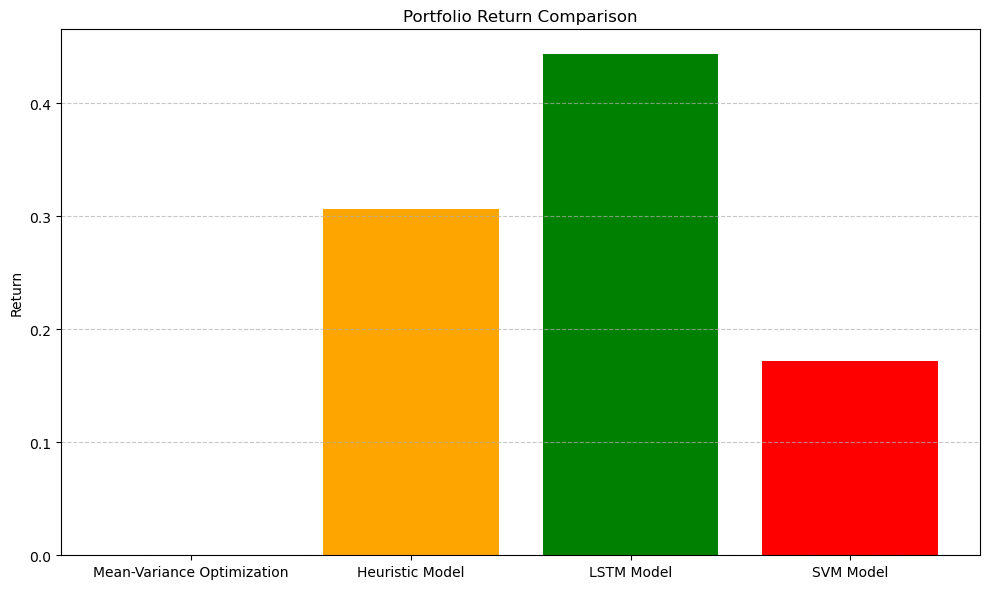

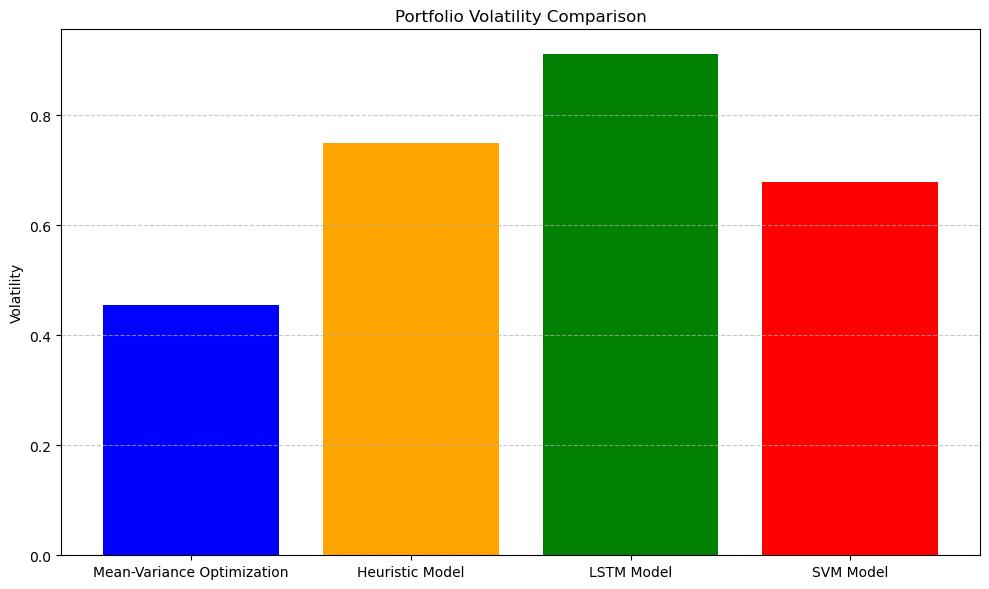

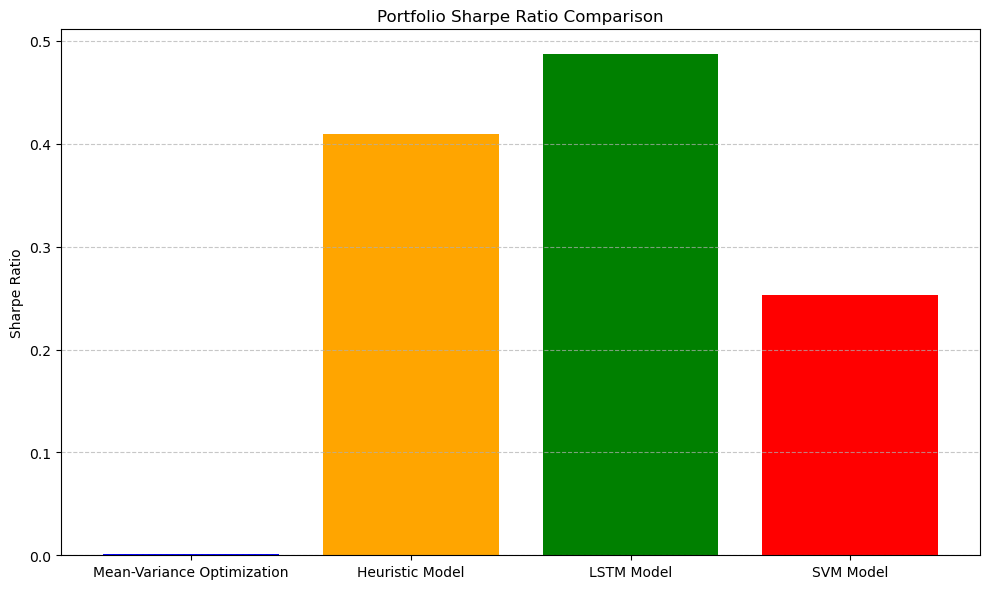

In [124]:
metrics = ["Return", "Volatility", "Sharpe Ratio"]
for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.bar(methods, metrics_df[metric], color=["blue", "orange", "green", "red"])
    plt.title(f"Portfolio {metric} Comparison")
    plt.ylabel(metric)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# Impact of ESG Integration on Sectoral Allocations

In [125]:
print(sp500_merged['Sector'].unique())

['Technology' 'Basic Materials' 'Consumer Cyclical' 'Healthcare'
 'Industrials' 'Utilities' 'Financial Services' 'Energy' 'Real Estate'
 'Communication Services' 'Consumer Defensive' 'Unknown']


In [126]:
def sectoral_allocation_analysis(data, financial_columns, sector_data, esg_scores, penalty_factors):
    
    # Ensuring financial data aligns with the number of columns
    
    financial_data = data[financial_columns].dropna()
    mean_returns = financial_data.mean(axis=0).values
    cov_matrix = financial_data.cov().values

    # Ensuring ESG scores align with financial columns
    
    if len(esg_scores) != len(financial_columns):
        raise ValueError(f"ESG scores ({len(esg_scores)}) do not match financial columns ({len(financial_columns)}).")

    # Dictionary to store results for each penalty factor
    
    sector_results = {}
    for factor in penalty_factors:
        # Optimize portfolio for the given penalty factor
        esg_weights = optimize_portfolio_tuned(mean_returns, cov_matrix, esg_scores, penalty_factor=factor)
        # Create a DataFrame for sector allocations
        sector_allocation = pd.DataFrame({
            'Asset': financial_columns,
            'Weight': esg_weights,
            'Sector': sector_data
        }).groupby('Sector').sum()
        
        # Saving sector weights for the current penalty factor
        
        sector_results[f"Penalty: {factor}"] = sector_allocation['Weight']

    # Combining results into a single DataFrame
    
    sector_df = pd.DataFrame(sector_results).fillna(0)  # Fill missing sectors with 0 allocation
    return sector_df

In [127]:
sector_data = [
    'Technology', 'Basic Materials', 'Consumer Cyclical', 'Healthcare', 'Industrials',
    'Utilities', 'Financial Services', 'Energy', 'Real Estate', 'Communication Services',
    'Consumer Defensive', 'Unknown'
]

# Dynamically aligning sector_data to financial_columns

sector_data = (sector_data * (len(financial_columns) // len(sector_data) + 1))[:len(financial_columns)]

# Dynamically aligning esg_scores to financial_columns

if len(esg_scores) < len(financial_columns):
    esg_scores = np.tile(esg_scores, len(financial_columns) // len(esg_scores) + 1)[:len(financial_columns)]
elif len(esg_scores) > len(financial_columns):
    esg_scores = esg_scores[:len(financial_columns)]

# Verifying alignment

assert len(sector_data) == len(financial_columns), f"sector_data length {len(sector_data)} does not match financial_columns length {len(financial_columns)}"
assert len(esg_scores) == len(financial_columns), f"esg_scores length {len(esg_scores)} does not match financial_columns length {len(financial_columns)}"

Analyzing and Plotting Sectoral Allocations

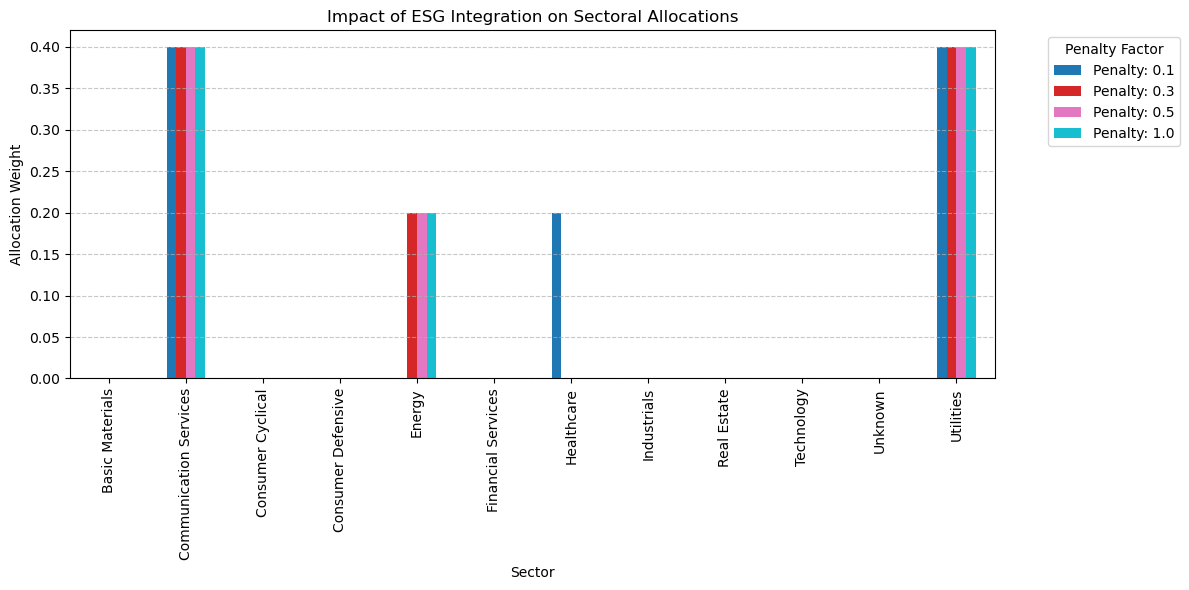

In [128]:
penalty_factors = [0.1, 0.3, 0.5, 1.0]
sectoral_allocation = sectoral_allocation_analysis(sp500_merged, financial_columns, sector_data, esg_scores, penalty_factors)

sectoral_allocation.plot(kind='bar', figsize=(12, 6), colormap='tab10')
plt.title('Impact of ESG Integration on Sectoral Allocations')
plt.xlabel('Sector')
plt.ylabel('Allocation Weight')
plt.legend(title='Penalty Factor', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Sensitivity Analysis with Wider Range of Penalty Factors

In [130]:
sensitivity_penalty_factors = [0.01, 0.1, 0.3, 0.5, 0.8, 1.0, 2.0, 5.0]

# Extracting financial data and calculating mean and covariance

financial_data = sp500_merged[financial_columns].dropna()
mean_returns = financial_data.mean(axis=0).values  # Ensure a 1D array
cov_matrix = financial_data.cov().values

# Ensuring ESG scores match the number of financial columns

esg_scores = sp500_merged['Total ESG Risk score'].dropna().values
esg_scores = np.tile(esg_scores, len(financial_columns) // len(esg_scores) + 1)[:len(financial_columns)]

In [131]:
# Analyzing sensitivity to penalty factors

results = {}
for factor in sensitivity_penalty_factors:
    weights = optimize_portfolio_tuned(mean_returns, cov_matrix, esg_scores, penalty_factor=factor)
    
    # Computing metrics for the given penalty factor
    
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    esg_score = np.dot(weights, esg_scores)
    rolling_max = np.maximum.accumulate(np.dot(financial_data.values, weights))
    drawdown = (rolling_max - np.dot(financial_data.values, weights)) / rolling_max
    max_drawdown = np.max(drawdown)

    # Storing metrics
    
    results[factor] = [portfolio_return, portfolio_volatility, sharpe_ratio, esg_score, max_drawdown]

# Creating a DataFrame for results

sensitivity_df = pd.DataFrame(results, index=['Return', 'Volatility', 'Sharpe Ratio', 'ESG Score', 'Max Drawdown']).T

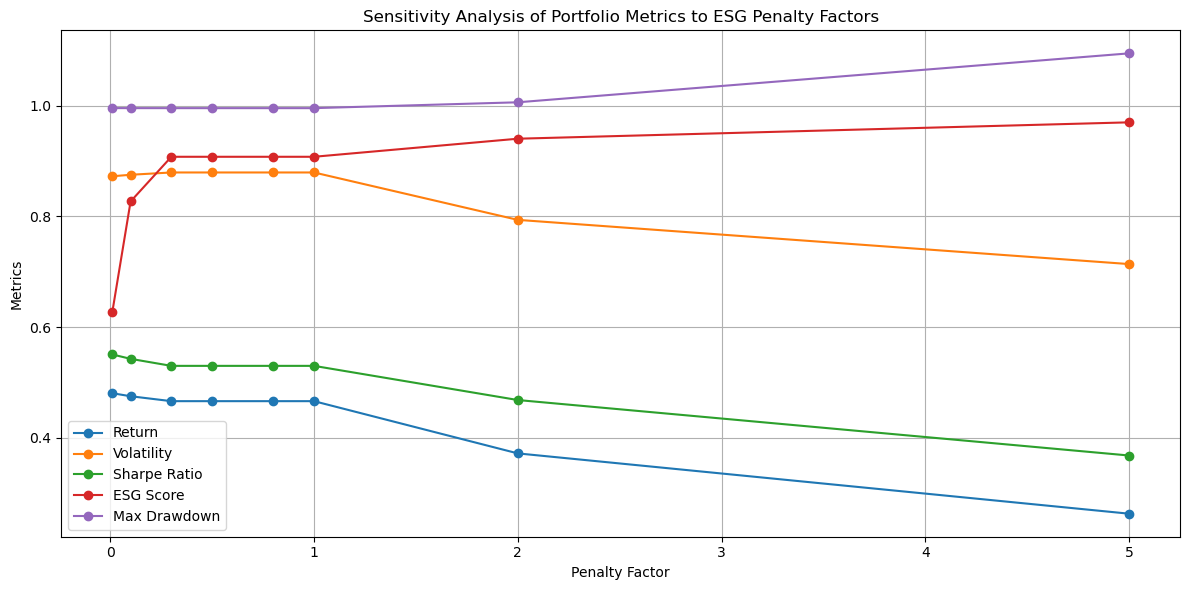

In [132]:
# Plotting Sensitivity Analysis

plt.figure(figsize=(12, 6))
for metric in ['Return', 'Volatility', 'Sharpe Ratio', 'ESG Score', 'Max Drawdown']:
    plt.plot(sensitivity_df.index, sensitivity_df[metric], marker='o', label=metric)

plt.title('Sensitivity Analysis of Portfolio Metrics to ESG Penalty Factors')
plt.xlabel('Penalty Factor')
plt.ylabel('Metrics')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Asset-Wise or Sector-Wise ESG Compliance Visualization

In [133]:
def asset_sector_esg_compliance(data, financial_columns, sector_data, esg_scores, penalty_factor):
    
    financial_data = data[financial_columns].dropna()
    mean_returns = financial_data.mean(axis=0).values
    cov_matrix = financial_data.cov().values

    esg_weights = optimize_portfolio_tuned(mean_returns, cov_matrix, esg_scores, penalty_factor=penalty_factor)
    asset_compliance = pd.DataFrame({
        'Asset': financial_columns,
        'Weight': esg_weights,
        'Sector': sector_data,
        'ESG Score': esg_scores
    })

    # Calculating sector-wise ESG compliance
    
    sector_compliance = asset_compliance.groupby('Sector').apply(
        lambda x: (x['Weight'] * x['ESG Score']).sum() / x['Weight'].sum()
    ).reset_index(name='Weighted ESG Compliance')

    return asset_compliance, sector_compliance

# Asset-level and Sector-Level ESG Compliance

penalty_factor_for_analysis = 0.5  # Example penalty factor
asset_compliance, sector_compliance = asset_sector_esg_compliance(
    sp500_merged, financial_columns, sector_data, esg_scores, penalty_factor_for_analysis
)

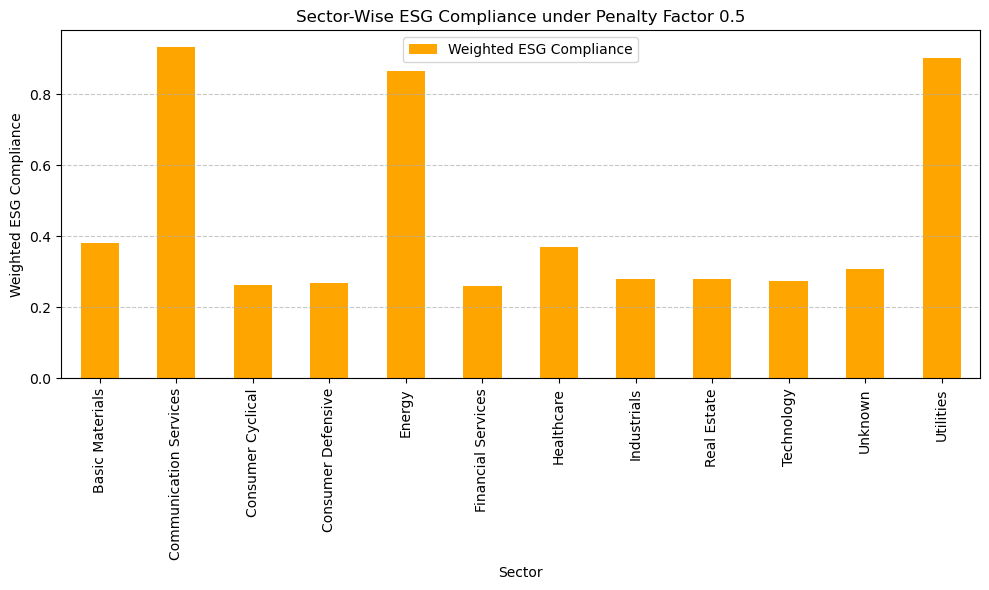

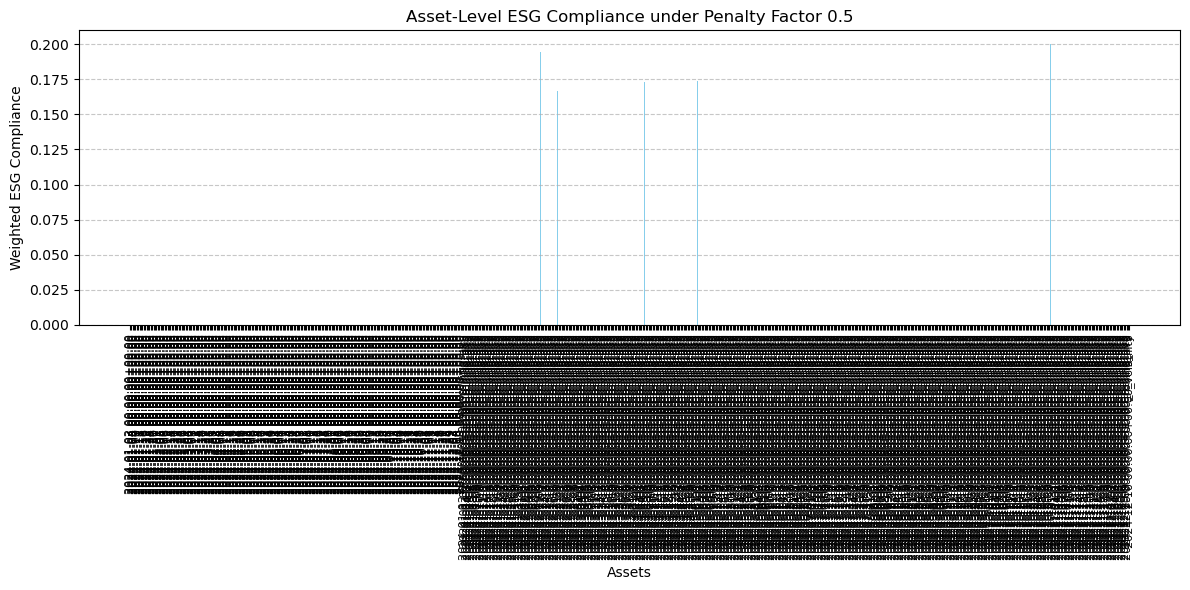

In [134]:
# Visualizing Sector-Wise ESG Compliance

sector_compliance.plot(x='Sector', y='Weighted ESG Compliance', kind='bar', figsize=(10, 6), color='orange')
plt.title('Sector-Wise ESG Compliance under Penalty Factor 0.5')
plt.xlabel('Sector')
plt.ylabel('Weighted ESG Compliance')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Visualize Asset-Level ESG Compliance

plt.figure(figsize=(12, 6))
plt.bar(asset_compliance['Asset'], asset_compliance['Weight'] * asset_compliance['ESG Score'], color='skyblue')
plt.title('Asset-Level ESG Compliance under Penalty Factor 0.5')
plt.xlabel('Assets')
plt.ylabel('Weighted ESG Compliance')
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()